In [1]:
import sys
import multiprocessing



import os
import random
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models


import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


if sys.platform == 'darwin':
    multiprocessing.set_start_method('fork', force=True)
# это необходимо, тк DataLoader работает с многопотчностью, которая по дефолту заблокирована на macOS

# Часть 1. Dataset и DataLoader

In [322]:

class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, class_idx=['n02132136','n04146614','n07873807','n02364673','n04507155','n03854065','n03838899','n03733131','n01443537','n07875152']):
        """
        root_dir: путь до папки tiny-imagenet-200
        split: 'train', 'val' или 'test'
        transform: трансформации изображений
        class_idx: классы, что берутся в датасет
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform


        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]

        self.class_to_idx = { name: i   for i, name in enumerate(class_idx)}
        self.samples = []
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                if cls not in class_idx:
                    continue
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls not in class_idx:
                    continue
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))  # тест без меток

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


In [323]:
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize((72, 72)),                    
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
root = "data/tiny-imagenet-200"


train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform)
val_dataset = TinyImageNetDataset(root, split='val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=2)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")

Train size: 5000
Val size: 500


Python(14446) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


/Users/kimelfeld/Library/Python/3.9/lib/python/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/kimelfeld/Library/Python/3.9/lib/python/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
Python(14447) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


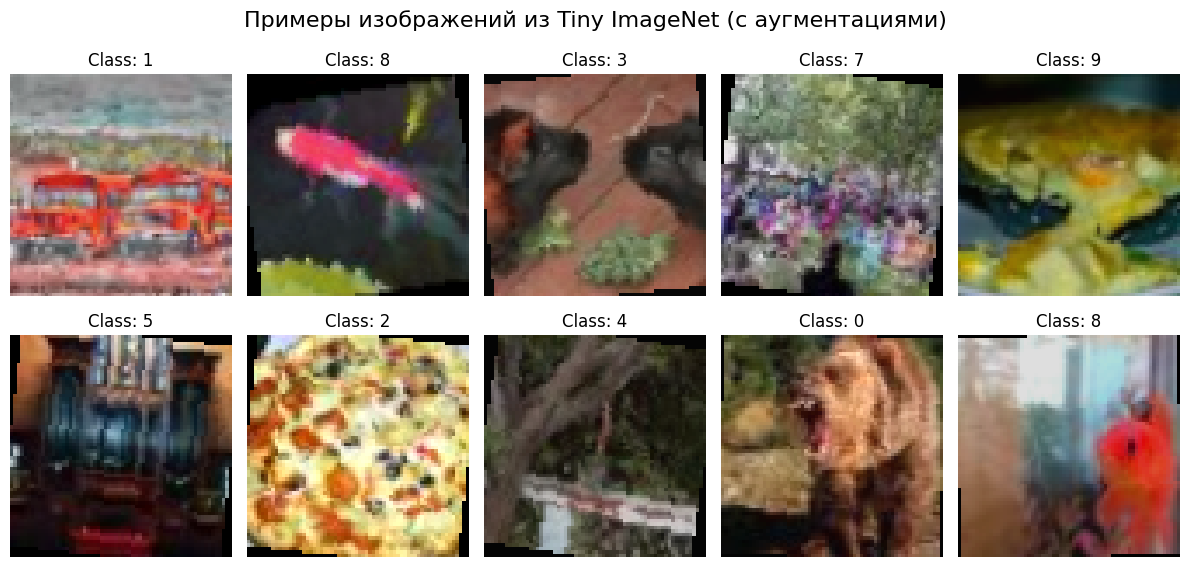

Размер батча: torch.Size([10, 3, 64, 64])
Диапазон значений: [-2.118, 2.640]
Метки классов: [1, 8, 3, 7, 9, 5, 2, 4, 0, 8]
Всего классов в датасете: 10
Названия классов: dict_keys(['n02132136', 'n04146614', 'n07873807', 'n02364673', 'n04507155', 'n03854065', 'n03838899', 'n03733131', 'n01443537', 'n07875152'])


In [324]:
images, labels = next(iter(train_loader))
# за один getitem выходит 1 batch

def denormalize(img_tensor):
    """Вернём изображение из нормализованного диапазона в [0,1]"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
    img = img_tensor.permute(1, 2, 0) * std + mean
    return img.clamp(0, 1)

images_vis = images.permute(0, 2, 3, 1)

images_vis = torch.stack([denormalize(img) for img in images])

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images_vis[i])
    plt.title(f"Class: {labels[i].item()}")
    plt.axis('off')

plt.suptitle("Примеры изображений из Tiny ImageNet (с аугментациями)", fontsize=16)
plt.tight_layout()
plt.show()

print(f"Размер батча: {images.shape}")
print(f"Диапазон значений: [{images.min():.3f}, {images.max():.3f}]")
print(f"Метки классов: {labels.tolist()}")
print(f"Всего классов в датасете: {len(train_dataset.class_to_idx)}")
print(f"Названия классов: {train_dataset.class_to_idx.keys()}")

In [327]:
images

tensor([[[[ 0.3138,  0.1939,  0.1254,  ...,  0.1254,  0.0912,  0.1426],
          [ 0.1083,  0.0569,  0.0398,  ...,  0.2111,  0.1768,  0.1768],
          [ 0.0398,  0.0569,  0.0398,  ...,  0.4337,  0.4508,  0.4337],
          ...,
          [-0.2342, -0.3369,  0.0569,  ...,  0.1939,  0.2111,  0.1939],
          [-0.3541, -0.0116,  0.1083,  ...,  0.2111, -0.0629,  0.0741],
          [ 0.7591,  1.0159,  1.2214,  ...,  1.8379,  0.9646,  0.6906]],

         [[ 0.4853,  0.3803,  0.3277,  ...,  0.2752,  0.2402,  0.2927],
          [ 0.3102,  0.2577,  0.2227,  ...,  0.3452,  0.3277,  0.3452],
          [ 0.2227,  0.2402,  0.2227,  ...,  0.6254,  0.6254,  0.6254],
          ...,
          [-1.0028, -1.1078, -0.7402,  ..., -0.2150, -0.1275, -0.1275],
          [-0.9853, -0.6702, -0.5126,  ...,  0.0301, -0.2850, -0.1099],
          [ 0.2402,  0.5028,  0.7129,  ...,  1.9909,  0.8880,  0.5028]],

         [[ 0.7054,  0.6008,  0.5485,  ...,  0.5136,  0.4788,  0.5311],
          [ 0.5311,  0.4788,  

In [328]:
np.unique( list(dict(train_dataset).values()))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Часть 2. ResNet-18

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):

    """
    Базовый блок ResNet с residual connection
    
    Args:
        in_channels (int): количество входных каналов
        out_channels (int): количество выходных каналов
        stride (int): шаг свертки (по умолчанию 1)
        downsample (nn.Module): слой для изменения размерности (если нужно)
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.Conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.Conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1,stride=1)
        self.Bn1 = nn.BatchNorm2d(out_channels)
        self.Bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        if stride !=  1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                     stride=stride),
            nn.BatchNorm2d(out_channels),
        )
        else:
            self.downsample=None
        

    def forward(self, x):
   
        x_first_conv = self.relu(self.Bn1(self.Conv_1(x)))
        x_double_conv = self.Bn2(self.Conv_2(x_first_conv))
        if self.downsample is not None:
            x = self.downsample(x)
        out = self.relu(x_double_conv + x) # <- residual connection 
        return out  





basic_block = BasicBlock(64, 64)
test_input = torch.randn(2, 64, 32, 32)

output = basic_block(test_input)

In [352]:
output[1].shape

torch.Size([64, 32, 32])

In [353]:
## ResNet
class MyFirstResNet(nn.Module):
    def __init__(self,  num_classes=10):
        super().__init__()
        self.conv2d = nn.Conv2d(3, 64, kernel_size=3,stride=1)
        self.layer_1 = nn.Sequential( BasicBlock(64, 64,), BasicBlock(64, 64))
        self.layer_2 = nn.Sequential( BasicBlock(64, 128, stride=2, downsample=True), BasicBlock(128, 128))
        self.layer_3 = nn.Sequential( BasicBlock(128, 256, stride=2, downsample=True), BasicBlock(256, 256))
        #
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.max_pool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        #
        self.mlp = nn.Linear(in_features=256,out_features=num_classes)
        self.Bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.Bn(self.conv2d(x))
        x = self.relu(x)
        x = self.max_pool(x)
        x_l1 = self.layer_1(x)
        x_l2 = self.layer_2(x_l1)
        x_l3 = self.layer_3(x_l2)
        X = self.gap(x_l3)
        X = X.squeeze(-1).squeeze(-1)
        out = self.mlp(X)
        return  out

In [354]:
test_input = torch.randn(10, 3, 64, 64)
resnet = MyFirstResNet()
out = resnet(test_input)

In [355]:
out

tensor([[-2.9753e-01,  5.4119e-02, -4.6005e-01,  1.7787e-02, -2.5383e-01,
         -3.0754e-01,  5.8732e-03, -8.5519e-02, -1.0214e+00, -6.7339e-01],
        [-6.3790e-02, -1.5783e-02, -3.0571e-01,  1.2047e-01, -2.0868e-01,
         -2.3515e-01,  3.0074e-03, -4.6947e-02, -8.5691e-01, -7.7931e-01],
        [-1.1653e-02,  4.8575e-02, -3.0691e-01,  1.5482e-01, -1.5705e-01,
         -2.4407e-01,  1.1924e-02, -3.1742e-02, -1.0554e+00, -6.9608e-01],
        [-1.1448e-01,  8.5485e-02, -4.0896e-01,  9.6938e-02, -2.7227e-01,
         -2.2209e-01, -1.1274e-01, -5.1211e-02, -9.0367e-01, -6.7014e-01],
        [-1.5950e-01,  3.8095e-02, -3.0046e-01,  8.0569e-02, -2.4002e-01,
         -2.1281e-01,  1.5427e-02, -1.2552e-01, -1.0360e+00, -8.0252e-01],
        [-1.8462e-01, -1.7171e-02, -3.3695e-01,  9.2061e-02, -2.5683e-01,
         -2.5750e-01, -3.6105e-02, -2.1366e-01, -9.9494e-01, -6.5776e-01],
        [-2.2090e-01,  7.7354e-02, -2.7826e-01,  8.0718e-02, -2.0870e-01,
         -2.6375e-01,  2.6867e-0

In [356]:
def train_epoch(model, train_loader, optimizer, criterion, device ):
    """
    Функция для одного эпоха обучения
    
    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        train_loss: средняя потеря за эпох
        train_acc: средняя точность за эпох
    """
    model.train()  # Переводим модель в режим обучения
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    

    pbar = tqdm(train_loader, desc="Training")
    
    for batch_idx, (data, target) in enumerate(pbar):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item() * target.size(0)
        y_pred = torch.argmax(outputs,dim=-1)
        correct += torch.sum(y_pred == target)
        loss.backward()
        optimizer.step()
        total += target.size(0)
        pbar.set_postfix({
            'Loss per batch': f'{loss.item():.4f}',
            'Acc per batch': f'{torch.sum(y_pred == target) * 100/ target.size(0):.1f}'
        })
        
    return running_loss/total, correct/total


def validate_epoch(model, val_loader, criterion, device):
    """
    Функция для валидации модели
    
    Args:
        model: модель для валидации
        val_loader: DataLoader с валидационными данными
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        val_loss: средняя потеря на валидации
        val_acc: средняя точность на валидации
    """
    model.eval()  # Переводим модель в режим оценки
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(val_loader, desc="Validation")
    
    with torch.no_grad():  # Отключаем вычисление градиентов
        running_loss = 0.0
        correct = 0
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            total +=  target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)
            running_loss += loss.item() * target.size(0)
            y_pred = torch.argmax(outputs, dim=-1)
            correct += torch.sum(y_pred == target)
            pbar.set_postfix({
            'Loss per batch': f'{loss.item():.4f}',
            'Acc per batch': f'{torch.sum(y_pred == target) * 100/ target.size(0):.2f}'
        })
    return running_loss/total, correct/total

In [357]:
len(train_loader)

10

In [358]:
selected_classes = [2, 4, 5]

subset_train_samples = [s for s in train_dataset.samples if s[1] in selected_classes]
subset_val_samples = [s for s in val_dataset.samples if s[1] in selected_classes]

print(f"Используем {len(subset_train_samples)} train и {len(subset_val_samples)} val изображений "
      f"из {len(selected_classes)} классов")


# def remap_samples(samples,class_to_new_idx):
#     return [(path, class_to_new_idx[label]) for path, label in samples]

# subset_train_samples = remap_samples(subset_train_samples, class_to_new_idx=class_to_new_idx)
# subset_val_samples = remap_samples(subset_val_samples, class_to_new_idx=class_to_new_idx)

class CustomDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


train_subset_dataset = CustomDataset(subset_train_samples, transform=train_transform)
val_subset_dataset = CustomDataset(subset_val_samples, transform=val_transform)

train_loader = DataLoader(train_subset_dataset, batch_size=64, shuffle=True, num_workers=3)
val_loader = DataLoader(val_subset_dataset, batch_size=64, shuffle=False, num_workers=3)



Используем 1500 train и 150 val изображений из 3 классов


In [359]:
#np.unique( list(dict(train_loader.dataset).values())) Проверка меток

resnet = MyFirstResNet(3).to(torch.device('mps'))
criterion = nn.CrossEntropyLoss()
from torch.optim import Adam
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)


for _ in range(2):
    train_epoch(resnet, train_loader, optimizer, criterion, torch.device('mps'))


Training:   0%|          | 0/24 [00:00<?, ?it/s]Python(34369) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34370) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/kimelfeld/Library/Python/3.9/lib/python/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/kimelfeld/Library/Python/3.9/lib/python/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threa

In [360]:
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)
validate_epoch(resnet, train_loader, criterion,torch.device('mps'))

Validation:   0%|          | 0/24 [00:00<?, ?it/s]Python(34526) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34527) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/kimelfeld/Library/Python/3.9/lib/python/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/kimelfeld/Library/Python/3.9/lib/python/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_thr

(0.0002969203412067145, tensor(0.3333, device='mps:0'))

## 2.1 Запуск модели - обучение

In [376]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10, experiment = 'Baseline', var=None):
    """
    Основная функция для обучения модели
    
    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        val_loader: DataLoader с валидационными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
        num_epochs: количество эпох
    
    Returns:
        history: словарь с историей обучения
    """
    print(f"Обучение на {num_epochs} эпох...")
    save_dir = './training_results'
    save_path = os.path.join(save_dir,experiment,var) if var is not None else os.path.join(save_dir,experiment) 
    print(f'Лучшая эпоха будет сохранена в {save_path}')
    os.makedirs(save_path, exist_ok=True)
    best_model_path = os.path.join(save_path, 'best_model.pth')

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    model = model.to(device)
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f" Эпоха {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device )
        
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device )
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc * 100:.2f}%")
        print(f" Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f" Сохранена лучшая модель с точностью {val_acc * 100:.2f}%")
        
    
    return history


def plot_training_history(history, save_dir="./training_results", experiment = 'Baseline', var=None):
    
    save_path = os.path.join(save_dir,experiment,var) if var is not None else os.path.join(save_dir,experiment) 
    os.makedirs(save_path, exist_ok=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    list_to_np = lambda x:  [el.detach().numpy() for el in x]
    #
    print(f'История сохранена в {save_path}')
    #
    ax1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'loss_plot.png'), dpi=300, bbox_inches='tight')


    ax2.plot(list_to_np(history['train_acc']), label='Train Accuracy', color='blue')
    ax2.plot(list_to_np(history['val_acc']), label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'accuracy_plot.png'), dpi=300, bbox_inches='tight')
    plt.show()

    history_file = os.path.join(save_path, 'training_history.txt')
    with open(history_file, 'w') as f:
        f.write("Epoch\tTrain_Loss\tVal_Loss\tTrain_Acc\tVal_Acc\n")
        for i in range(len(history['train_loss'])):
            f.write(f"{i+1}\t{history['train_loss'][i]:.4f}\t{history['val_loss'][i]:.4f}\t"
                   f"{history['train_acc'][i]:.2f}\t{history['val_acc'][i]:.2f}\n")
    
    print(f"Результаты сохранены в папку: {save_path}")

In [377]:
train_transform = transforms.Compose([
    transforms.Resize((72, 72)),                    
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
root = "data/tiny-imagenet-200"


train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform)
val_dataset = TinyImageNetDataset(root, split='val', transform=val_transform)



train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)



In [363]:
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)},")

# Проверить пересечения
train_files = set(train_dataset.samples)
val_files = set(val_dataset.samples) 

print(f"Train-Val overlap: {len(train_files & val_files)}")


Train: 5000, Val: 500,
Train-Val overlap: 0


In [364]:
model = MyFirstResNet(num_classes=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cpu')
#if torch.backends.mps.is_available() else 'mps')

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20
)

Обучение на 20 эпох...
Лучшая эпоха будет сохранена в ./training_results/Baseline
 Эпоха 1/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, Loss per batch=2.1498, Acc per batch=32.60]


 Train Loss: 2.0176, Train Acc: 30.40%
 Val Loss: 2.1498, Val Acc: 32.60%
 Сохранена лучшая модель с точностью 32.60%
 Эпоха 2/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, Loss per batch=1.9177, Acc per batch=36.40]


 Train Loss: 1.5238, Train Acc: 47.12%
 Val Loss: 1.9177, Val Acc: 36.40%
 Сохранена лучшая модель с точностью 36.40%
 Эпоха 3/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it, Loss per batch=1.7790, Acc per batch=42.80]


 Train Loss: 1.3344, Train Acc: 53.90%
 Val Loss: 1.7790, Val Acc: 42.80%
 Сохранена лучшая модель с точностью 42.80%
 Эпоха 4/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, Loss per batch=2.0988, Acc per batch=43.20]


 Train Loss: 1.2226, Train Acc: 57.68%
 Val Loss: 2.0988, Val Acc: 43.20%
 Сохранена лучшая модель с точностью 43.20%
 Эпоха 5/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, Loss per batch=2.1616, Acc per batch=39.60]


 Train Loss: 1.1615, Train Acc: 60.22%
 Val Loss: 2.1616, Val Acc: 39.60%
 Эпоха 6/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it, Loss per batch=3.3758, Acc per batch=29.00]


 Train Loss: 1.0922, Train Acc: 62.38%
 Val Loss: 3.3758, Val Acc: 29.00%
 Эпоха 7/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it, Loss per batch=3.6983, Acc per batch=29.00]


 Train Loss: 1.0252, Train Acc: 63.80%
 Val Loss: 3.6983, Val Acc: 29.00%
 Эпоха 8/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, Loss per batch=1.8232, Acc per batch=46.00]


 Train Loss: 1.0152, Train Acc: 65.08%
 Val Loss: 1.8232, Val Acc: 46.00%
 Сохранена лучшая модель с точностью 46.00%
 Эпоха 9/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it, Loss per batch=2.2856, Acc per batch=41.40]


 Train Loss: 0.9633, Train Acc: 66.12%
 Val Loss: 2.2856, Val Acc: 41.40%
 Эпоха 10/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, Loss per batch=2.0393, Acc per batch=42.80]


 Train Loss: 0.9013, Train Acc: 69.40%
 Val Loss: 2.0393, Val Acc: 42.80%
 Эпоха 11/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it, Loss per batch=1.8894, Acc per batch=44.20]


 Train Loss: 0.8540, Train Acc: 70.42%
 Val Loss: 1.8894, Val Acc: 44.20%
 Эпоха 12/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, Loss per batch=1.7725, Acc per batch=51.20]


 Train Loss: 0.8308, Train Acc: 70.92%
 Val Loss: 1.7725, Val Acc: 51.20%
 Сохранена лучшая модель с точностью 51.20%
 Эпоха 13/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it, Loss per batch=1.3325, Acc per batch=56.00]


 Train Loss: 0.8094, Train Acc: 71.64%
 Val Loss: 1.3325, Val Acc: 56.00%
 Сохранена лучшая модель с точностью 56.00%
 Эпоха 14/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it, Loss per batch=2.9659, Acc per batch=37.00]


 Train Loss: 0.7814, Train Acc: 72.32%
 Val Loss: 2.9659, Val Acc: 37.00%
 Эпоха 15/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, Loss per batch=1.2962, Acc per batch=59.60]


 Train Loss: 0.7594, Train Acc: 73.24%
 Val Loss: 1.2962, Val Acc: 59.60%
 Сохранена лучшая модель с точностью 59.60%
 Эпоха 16/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, Loss per batch=1.5882, Acc per batch=49.60]


 Train Loss: 0.7118, Train Acc: 75.30%
 Val Loss: 1.5882, Val Acc: 49.60%
 Эпоха 17/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it, Loss per batch=1.5983, Acc per batch=51.40]


 Train Loss: 0.7236, Train Acc: 74.88%
 Val Loss: 1.5983, Val Acc: 51.40%
 Эпоха 18/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it, Loss per batch=1.4184, Acc per batch=50.80]


 Train Loss: 0.7120, Train Acc: 75.10%
 Val Loss: 1.4184, Val Acc: 50.80%
 Эпоха 19/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  3.00s/it, Loss per batch=1.6261, Acc per batch=52.00]


 Train Loss: 0.6641, Train Acc: 76.84%
 Val Loss: 1.6261, Val Acc: 52.00%
 Эпоха 20/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, Loss per batch=4.6720, Acc per batch=28.20]

 Train Loss: 0.6413, Train Acc: 77.60%
 Val Loss: 4.6720, Val Acc: 28.20%


In [365]:
print(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('----------------------------------')
print(f" Всего параметров: {total_params:,}")
print(f" Обучаемых параметров: {trainable_params:,}")

MyFirstResNet(
  (conv2d): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (layer_1): Sequential(
    (0): BasicBlock(
      (Conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (Bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (Conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (Bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (layer_2): Sequential(
    (0): BasicBlock(
      (Conv_1): Conv2d(64, 12

История сохранена в ./training_results/Baseline


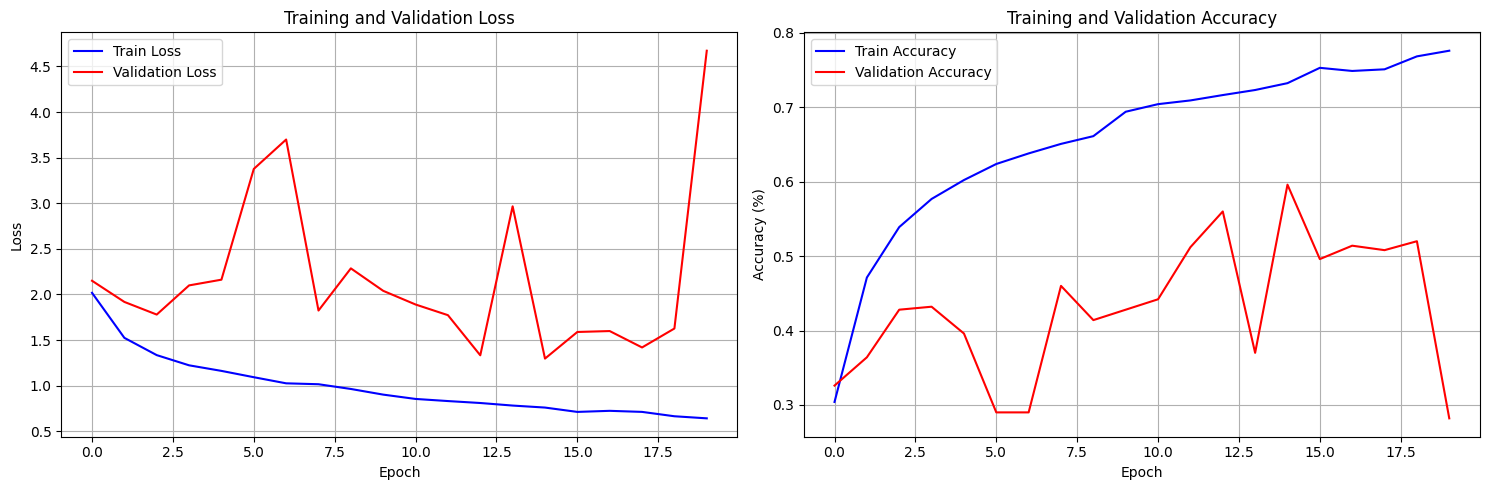

Результаты сохранены в папку: ./training_results/Baseline


In [379]:
plot_training_history(history)

# 3.1 Эксперимент с кол-вом каналов  

Вариант A: 32 → 64 → 128 → 256 каналов  

Вариант B: 64 → 128 → 256 каналов (без 4-го слоя)

In [380]:
def print_model_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('----------------------------------')
    print(f" Всего параметров: {total_params:,}")
    print(f" Обучаемых параметров: {trainable_params:,}")
    
class ResNet3_1A(nn.Module):
    def __init__(self,  num_classes=10):
        super().__init__()
        self.conv2d = nn.Conv2d(3, 64, kernel_size=3,stride=1)
        self.layer_1 = nn.Sequential(BasicBlock(64, 32, stride=1, downsample=True) , BasicBlock(32, 32) )
        self.layer_2 = nn.Sequential( BasicBlock(32, 64, stride=2, downsample=True), BasicBlock(64, 64)  )
        self.layer_3 = nn.Sequential( BasicBlock(64, 128, stride=2, downsample=True), BasicBlock(128, 128) )
        self.layer_4 = nn.Sequential( BasicBlock(128, 256, stride=2, downsample=True), BasicBlock(256,256) )
        #
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.max_pool = nn.MaxPool2d(3,2,1)
        #
        self.mlp = nn.Linear(in_features=256,out_features=num_classes)
        self.Bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.Bn(self.conv2d(x))
        x = self.relu(x)
        x = self.max_pool(x)
        x_l1 = self.layer_1(x)
        x_l2 = self.layer_2(x_l1)
        x_l3 = self.layer_3(x_l2)
        x_l4 = self.layer_4(x_l3)
        X = self.gap(x_l4)
        X = X.squeeze(-1).squeeze(-1)
        out = self.mlp(X)
        return  out
    
class ResNet3_1B(nn.Module):
    def __init__(self,  num_classes=10):
        super().__init__()
        self.conv2d = nn.Conv2d(3, 64, kernel_size=3,stride=1)
        self.layer_1 = nn.Sequential( BasicBlock(64, 64, stride=1), BasicBlock(64, 64))
        self.layer_2 = nn.Sequential( BasicBlock(64, 128, stride=2, downsample=True), BasicBlock(128, 128) )
        self.layer_3 = nn.Sequential( BasicBlock(128, 256, stride=2, downsample=True), BasicBlock(256,256) )
        #
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.max_pool = nn.MaxPool2d(3,2,1)
        #
        self.mlp = nn.Linear(in_features=256,out_features=num_classes)
        self.Bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.Bn(self.conv2d(x))
        x = self.relu(x)
        x = self.max_pool(x)
        x_l1 = self.layer_1(x)
        x_l2 = self.layer_2(x_l1)
        x_l3 = self.layer_3(x_l2)
        X = self.gap(x_l3)
        X = X.squeeze(-1).squeeze(-1)
        out = self.mlp(X)
        return  out

Модель варианта А
----------------------------------
 Всего параметров: 2,812,330
 Обучаемых параметров: 2,812,330
Модель варианта B
----------------------------------
 Всего параметров: 2,779,914
 Обучаемых параметров: 2,779,914
Обучение на 20 эпох...
Лучшая эпоха будет сохранена в ./training_results/3_1/A
 Эпоха 1/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, Loss per batch=2.0849, Acc per batch=22.80]


 Train Loss: 2.0967, Train Acc: 26.16%
 Val Loss: 2.0849, Val Acc: 22.80%
 Сохранена лучшая модель с точностью 22.80%
 Эпоха 2/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, Loss per batch=2.2165, Acc per batch=31.20]


 Train Loss: 1.5778, Train Acc: 44.30%
 Val Loss: 2.2165, Val Acc: 31.20%
 Сохранена лучшая модель с точностью 31.20%
 Эпоха 3/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, Loss per batch=1.6258, Acc per batch=48.60]


 Train Loss: 1.3937, Train Acc: 51.42%
 Val Loss: 1.6258, Val Acc: 48.60%
 Сохранена лучшая модель с точностью 48.60%
 Эпоха 4/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, Loss per batch=1.5191, Acc per batch=50.20]


 Train Loss: 1.2497, Train Acc: 56.40%
 Val Loss: 1.5191, Val Acc: 50.20%
 Сохранена лучшая модель с точностью 50.20%
 Эпоха 5/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, Loss per batch=1.6288, Acc per batch=47.40]


 Train Loss: 1.1602, Train Acc: 59.68%
 Val Loss: 1.6288, Val Acc: 47.40%
 Эпоха 6/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, Loss per batch=1.7533, Acc per batch=49.80]


 Train Loss: 1.0989, Train Acc: 62.24%
 Val Loss: 1.7533, Val Acc: 49.80%
 Эпоха 7/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, Loss per batch=2.2289, Acc per batch=35.20]


 Train Loss: 1.0532, Train Acc: 63.92%
 Val Loss: 2.2289, Val Acc: 35.20%
 Эпоха 8/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, Loss per batch=1.7456, Acc per batch=46.40]


 Train Loss: 0.9520, Train Acc: 67.06%
 Val Loss: 1.7456, Val Acc: 46.40%
 Эпоха 9/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, Loss per batch=1.8026, Acc per batch=43.80]


 Train Loss: 0.9352, Train Acc: 67.54%
 Val Loss: 1.8026, Val Acc: 43.80%
 Эпоха 10/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, Loss per batch=1.8645, Acc per batch=45.60]


 Train Loss: 0.8875, Train Acc: 68.74%
 Val Loss: 1.8645, Val Acc: 45.60%
 Эпоха 11/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, Loss per batch=1.6401, Acc per batch=53.60]


 Train Loss: 0.8599, Train Acc: 70.04%
 Val Loss: 1.6401, Val Acc: 53.60%
 Сохранена лучшая модель с точностью 53.60%
 Эпоха 12/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, Loss per batch=1.6502, Acc per batch=52.00]


 Train Loss: 0.7993, Train Acc: 72.38%
 Val Loss: 1.6502, Val Acc: 52.00%
 Эпоха 13/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, Loss per batch=2.0919, Acc per batch=45.40]


 Train Loss: 0.7868, Train Acc: 73.16%
 Val Loss: 2.0919, Val Acc: 45.40%
 Эпоха 14/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, Loss per batch=1.5182, Acc per batch=51.40]


 Train Loss: 0.7747, Train Acc: 72.84%
 Val Loss: 1.5182, Val Acc: 51.40%
 Эпоха 15/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, Loss per batch=2.1458, Acc per batch=41.60]


 Train Loss: 0.7112, Train Acc: 75.32%
 Val Loss: 2.1458, Val Acc: 41.60%
 Эпоха 16/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, Loss per batch=1.6913, Acc per batch=49.60]


 Train Loss: 0.7000, Train Acc: 75.94%
 Val Loss: 1.6913, Val Acc: 49.60%
 Эпоха 17/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, Loss per batch=2.3457, Acc per batch=39.40]


 Train Loss: 0.6916, Train Acc: 75.94%
 Val Loss: 2.3457, Val Acc: 39.40%
 Эпоха 18/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, Loss per batch=2.1302, Acc per batch=45.00]


 Train Loss: 0.6452, Train Acc: 77.02%
 Val Loss: 2.1302, Val Acc: 45.00%
 Эпоха 19/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, Loss per batch=1.2131, Acc per batch=60.40]


 Train Loss: 0.6365, Train Acc: 77.74%
 Val Loss: 1.2131, Val Acc: 60.40%
 Сохранена лучшая модель с точностью 60.40%
 Эпоха 20/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, Loss per batch=1.6571, Acc per batch=52.20]


 Train Loss: 0.5844, Train Acc: 79.84%
 Val Loss: 1.6571, Val Acc: 52.20%
История сохранена в ./training_results/3_1/A


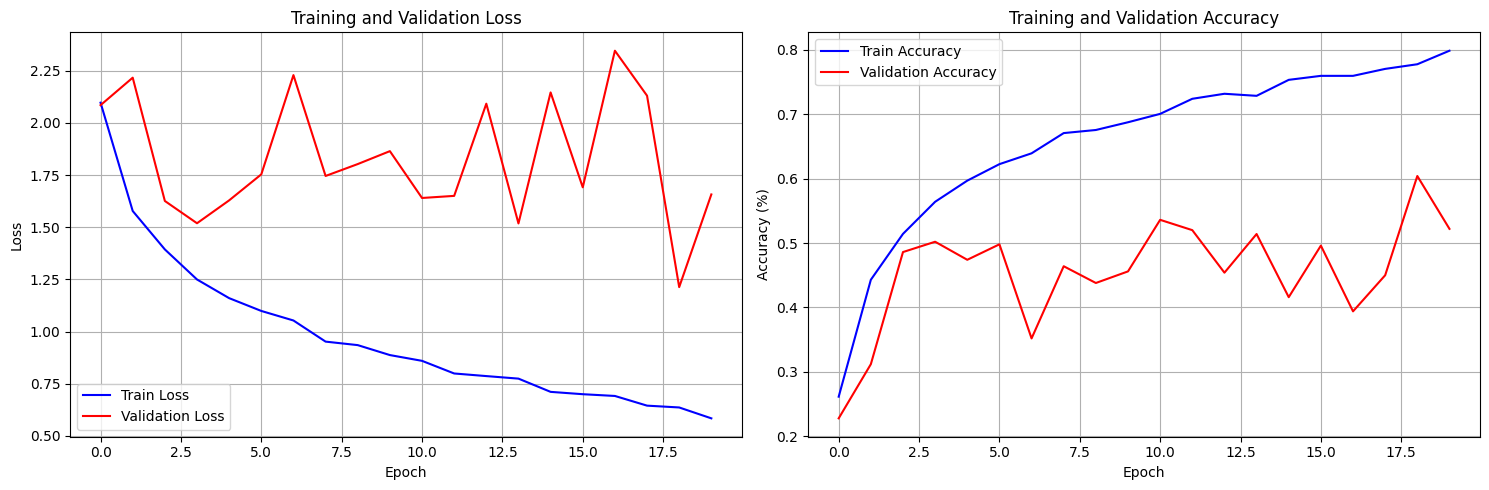

Результаты сохранены в папку: ./training_results/3_1/A


In [381]:
A , B  = ResNet3_1A(), ResNet3_1B()
print('Модель варианта А')
print_model_params(A)
print('Модель варианта B')
print_model_params(B)

optimizer = torch.optim.Adam(A.parameters(), lr=0.001)

history_3_1_A = train_model(
    model=A,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    experiment='3_1',
    var='A',
    num_epochs=20
)
plot_training_history(history_3_1_A,experiment='3_1',var='A')

Обучение на 20 эпох...
Лучшая эпоха будет сохранена в ./training_results/3_1/B
 Эпоха 1/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, Loss per batch=2.3437, Acc per batch=19.20]


 Train Loss: 1.9475, Train Acc: 32.32%
 Val Loss: 2.3437, Val Acc: 19.20%
 Сохранена лучшая модель с точностью 19.20%
 Эпоха 2/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it, Loss per batch=1.7566, Acc per batch=45.00]


 Train Loss: 1.4598, Train Acc: 49.08%
 Val Loss: 1.7566, Val Acc: 45.00%
 Сохранена лучшая модель с точностью 45.00%
 Эпоха 3/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, Loss per batch=1.2821, Acc per batch=54.80]


 Train Loss: 1.2916, Train Acc: 55.08%
 Val Loss: 1.2821, Val Acc: 54.80%
 Сохранена лучшая модель с точностью 54.80%
 Эпоха 4/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, Loss per batch=1.9956, Acc per batch=39.20]


 Train Loss: 1.2239, Train Acc: 57.56%
 Val Loss: 1.9956, Val Acc: 39.20%
 Эпоха 5/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it, Loss per batch=2.1675, Acc per batch=40.00]


 Train Loss: 1.1431, Train Acc: 60.62%
 Val Loss: 2.1675, Val Acc: 40.00%
 Эпоха 6/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, Loss per batch=1.9295, Acc per batch=44.40]


 Train Loss: 1.0520, Train Acc: 64.02%
 Val Loss: 1.9295, Val Acc: 44.40%
 Эпоха 7/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, Loss per batch=3.6784, Acc per batch=26.00]


 Train Loss: 0.9937, Train Acc: 65.28%
 Val Loss: 3.6784, Val Acc: 26.00%
 Эпоха 8/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, Loss per batch=1.8291, Acc per batch=47.40]


 Train Loss: 0.9582, Train Acc: 66.44%
 Val Loss: 1.8291, Val Acc: 47.40%
 Эпоха 9/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, Loss per batch=1.9634, Acc per batch=49.60]


 Train Loss: 0.8867, Train Acc: 69.68%
 Val Loss: 1.9634, Val Acc: 49.60%
 Эпоха 10/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, Loss per batch=2.0174, Acc per batch=44.80]


 Train Loss: 0.8625, Train Acc: 70.30%
 Val Loss: 2.0174, Val Acc: 44.80%
 Эпоха 11/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, Loss per batch=2.1012, Acc per batch=39.20]


 Train Loss: 0.8290, Train Acc: 72.10%
 Val Loss: 2.1012, Val Acc: 39.20%
 Эпоха 12/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, Loss per batch=1.3385, Acc per batch=53.60]


 Train Loss: 0.8060, Train Acc: 72.34%
 Val Loss: 1.3385, Val Acc: 53.60%
 Эпоха 13/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it, Loss per batch=1.9606, Acc per batch=45.80]


 Train Loss: 0.7446, Train Acc: 74.50%
 Val Loss: 1.9606, Val Acc: 45.80%
 Эпоха 14/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, Loss per batch=1.9721, Acc per batch=45.20]


 Train Loss: 0.7177, Train Acc: 74.62%
 Val Loss: 1.9721, Val Acc: 45.20%
 Эпоха 15/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, Loss per batch=1.8508, Acc per batch=48.00]


 Train Loss: 0.7162, Train Acc: 75.44%
 Val Loss: 1.8508, Val Acc: 48.00%
 Эпоха 16/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, Loss per batch=1.6524, Acc per batch=57.80]


 Train Loss: 0.6826, Train Acc: 76.06%
 Val Loss: 1.6524, Val Acc: 57.80%
 Сохранена лучшая модель с точностью 57.80%
 Эпоха 17/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, Loss per batch=2.0163, Acc per batch=46.80]


 Train Loss: 0.6509, Train Acc: 77.40%
 Val Loss: 2.0163, Val Acc: 46.80%
 Эпоха 18/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, Loss per batch=1.7049, Acc per batch=51.00]


 Train Loss: 0.6377, Train Acc: 78.00%
 Val Loss: 1.7049, Val Acc: 51.00%
 Эпоха 19/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, Loss per batch=1.7362, Acc per batch=53.20]


 Train Loss: 0.6048, Train Acc: 79.36%
 Val Loss: 1.7362, Val Acc: 53.20%
 Эпоха 20/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, Loss per batch=1.4620, Acc per batch=51.40]


 Train Loss: 0.5913, Train Acc: 79.48%
 Val Loss: 1.4620, Val Acc: 51.40%
История сохранена в ./training_results/3_1/B


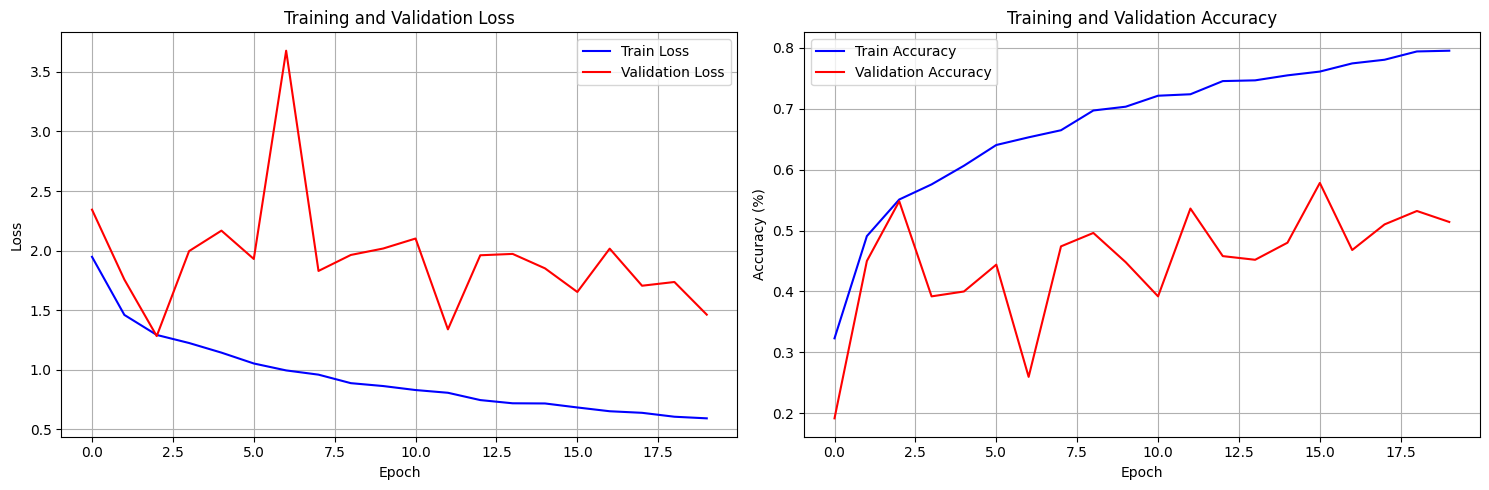

Результаты сохранены в папку: ./training_results/3_1/B


In [382]:
optimizer = torch.optim.Adam(B.parameters(), lr=0.001)

history_3_1_B = train_model(
    model=B,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    experiment='3_1',
    var='B',
    num_epochs=20


)
plot_training_history(history_3_1_B,experiment='3_1',var='B')

# 3.2 Эксперимент с кол-вом Residual блоков

Цель: Изучение влияния глубины сети (количества residual блоков) на производительность.

Эксперимент:

Используйте лучшую конфигурацию каналов из Этапа 3.1
  
Создайте 3 варианта модели с разным количеством блоков в каждом слое:  
  
Вариант A: [1, 1, 1, 1] - по 1 блоку в каждом слое (мелкая сеть)  
Вариант B: [2, 2, 2, 2] - по 2 блока в каждом слое (стандартная ResNet18)  
Вариант C: [3, 3, 3, 3] - по 3 блока в каждом слое (глубокая сеть)  

Обучите все три модели с одинаковыми гиперпараметрами
Архитектура вариантов:  


Вариант A (4 блока):  Layer1[1 блок] → Layer2[1 блок] → Layer3[1 блок] → Layer4[1 блок]  

Вариант B (8 блоков): Layer1[2 блока] → Layer2[2 блока] → Layer3[2 блока] → Layer4[2 блока]  

Вариант C (12 блоков): Layer1[3 блока] → Layer2[3 блока] → Layer3[3 блока] → Layer4[3 блока]  



In [387]:
## ResNet
class ResNet64(nn.Module):
    def __init__(self,  blocks, num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.conv2d = nn.Conv2d(3, 64, kernel_size=3,stride=1)
        self.layer_1 = self._make_layer( blocks[0], 64, stride=1)
        self.layer_2 = self._make_layer( blocks[1], 128, stride=2)
        self.layer_3 = self._make_layer( blocks[2], 256, stride=2)
        self.layer_4 = self._make_layer( blocks[3], 512, stride=2)
        #
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.max_pool = nn.MaxPool2d(3,2,1)
        #
        self.mlp = nn.Linear(in_features=512,out_features=num_classes)
        self.Bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

    def _make_layer(self, blocks, out_channels, stride=1):
        layers = []
        if stride != 1 or self.in_channels != out_channels:
            layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample=True))
        self.in_channels = out_channels
        # Последующие блоки - сохраняют размер
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels, stride=1,downsample=False))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.Bn(self.conv2d(x))
        x = self.relu(x)
        x = self.max_pool(x)
        x_l1 = self.layer_1(x)
        x_l2 = self.layer_2(x_l1)
        x_l3 = self.layer_3(x_l2)
        x_l4 = self.layer_4(x_l3)
        X = self.gap(x_l4)
        X = X.squeeze(-1).squeeze(-1)
        out = self.mlp(X)
        return  out

________________________________ VAR - A ____________________________________
----------------------------------
 Всего параметров: 4,832,010
 Обучаемых параметров: 4,832,010
Обучение на 20 эпох...
Лучшая эпоха будет сохранена в ./training_results/3_2/A
 Эпоха 1/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, Loss per batch=1.8710, Acc per batch=31.20]


 Train Loss: 1.9772, Train Acc: 32.80%
 Val Loss: 1.8710, Val Acc: 31.20%
 Сохранена лучшая модель с точностью 31.20%
 Эпоха 2/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it, Loss per batch=2.1807, Acc per batch=36.20]


 Train Loss: 1.4473, Train Acc: 49.40%
 Val Loss: 2.1807, Val Acc: 36.20%
 Сохранена лучшая модель с точностью 36.20%
 Эпоха 3/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it, Loss per batch=1.9120, Acc per batch=42.40]


 Train Loss: 1.2897, Train Acc: 56.08%
 Val Loss: 1.9120, Val Acc: 42.40%
 Сохранена лучшая модель с точностью 42.40%
 Эпоха 4/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it, Loss per batch=1.7267, Acc per batch=50.60]


 Train Loss: 1.1833, Train Acc: 58.64%
 Val Loss: 1.7267, Val Acc: 50.60%
 Сохранена лучшая модель с точностью 50.60%
 Эпоха 5/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, Loss per batch=1.3380, Acc per batch=55.00]


 Train Loss: 1.0797, Train Acc: 63.02%
 Val Loss: 1.3380, Val Acc: 55.00%
 Сохранена лучшая модель с точностью 55.00%
 Эпоха 6/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it, Loss per batch=1.5811, Acc per batch=53.00]


 Train Loss: 1.0001, Train Acc: 66.14%
 Val Loss: 1.5811, Val Acc: 53.00%
 Эпоха 7/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it, Loss per batch=1.4982, Acc per batch=54.00]


 Train Loss: 0.9716, Train Acc: 66.36%
 Val Loss: 1.4982, Val Acc: 54.00%
 Эпоха 8/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it, Loss per batch=1.9767, Acc per batch=43.60]


 Train Loss: 0.9136, Train Acc: 68.30%
 Val Loss: 1.9767, Val Acc: 43.60%
 Эпоха 9/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it, Loss per batch=1.2955, Acc per batch=57.40]


 Train Loss: 0.8562, Train Acc: 70.80%
 Val Loss: 1.2955, Val Acc: 57.40%
 Сохранена лучшая модель с точностью 57.40%
 Эпоха 10/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it, Loss per batch=1.2873, Acc per batch=57.60]


 Train Loss: 0.7968, Train Acc: 71.98%
 Val Loss: 1.2873, Val Acc: 57.60%
 Сохранена лучшая модель с точностью 57.60%
 Эпоха 11/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it, Loss per batch=1.5685, Acc per batch=53.00]


 Train Loss: 0.7729, Train Acc: 72.72%
 Val Loss: 1.5685, Val Acc: 53.00%
 Эпоха 12/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, Loss per batch=1.9103, Acc per batch=45.20]


 Train Loss: 0.7380, Train Acc: 74.64%
 Val Loss: 1.9103, Val Acc: 45.20%
 Эпоха 13/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, Loss per batch=1.6630, Acc per batch=51.60]


 Train Loss: 0.7467, Train Acc: 73.82%
 Val Loss: 1.6630, Val Acc: 51.60%
 Эпоха 14/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it, Loss per batch=1.5709, Acc per batch=56.80]


 Train Loss: 0.7143, Train Acc: 74.30%
 Val Loss: 1.5709, Val Acc: 56.80%
 Эпоха 15/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it, Loss per batch=1.4717, Acc per batch=57.40]


 Train Loss: 0.6850, Train Acc: 75.86%
 Val Loss: 1.4717, Val Acc: 57.40%
 Эпоха 16/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, Loss per batch=2.6479, Acc per batch=42.80]


 Train Loss: 0.6383, Train Acc: 77.68%
 Val Loss: 2.6479, Val Acc: 42.80%
 Эпоха 17/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, Loss per batch=2.1016, Acc per batch=45.40]


 Train Loss: 0.6066, Train Acc: 79.40%
 Val Loss: 2.1016, Val Acc: 45.40%
 Эпоха 18/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it, Loss per batch=2.1368, Acc per batch=48.20]


 Train Loss: 0.5819, Train Acc: 79.98%
 Val Loss: 2.1368, Val Acc: 48.20%
 Эпоха 19/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it, Loss per batch=1.7093, Acc per batch=53.40]


 Train Loss: 0.5837, Train Acc: 79.60%
 Val Loss: 1.7093, Val Acc: 53.40%
 Эпоха 20/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it, Loss per batch=2.3512, Acc per batch=42.40]


 Train Loss: 0.5676, Train Acc: 79.98%
 Val Loss: 2.3512, Val Acc: 42.40%
------------------------------------------------------------------------------------
История сохранена в ./training_results/3_2/A


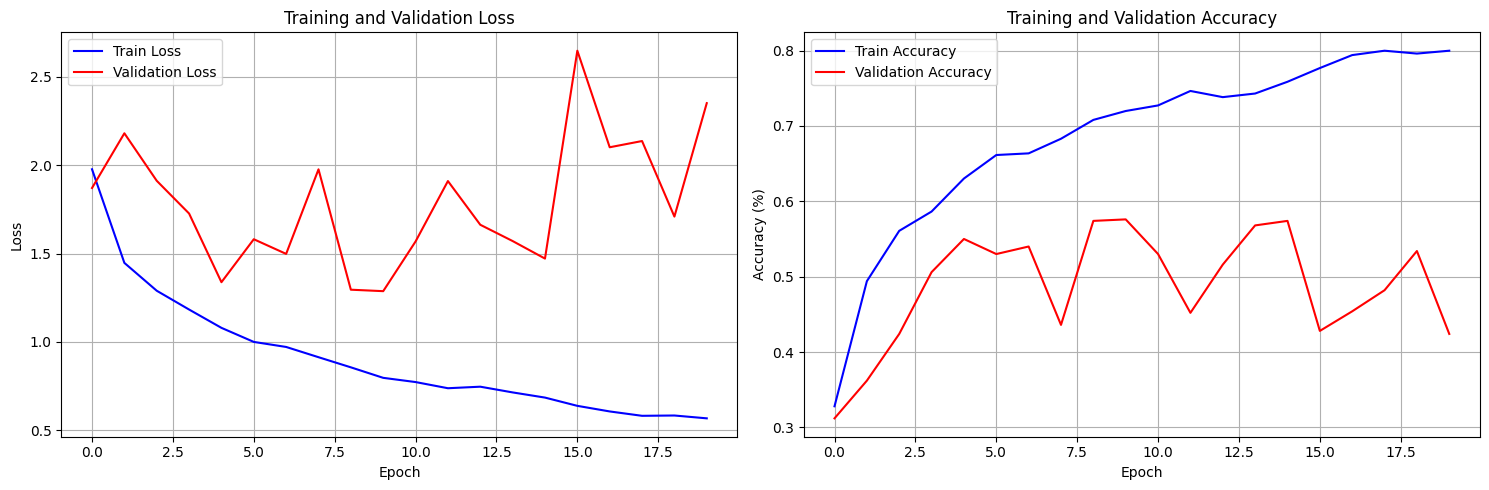

Результаты сохранены в папку: ./training_results/3_2/A
________________________________ VAR - B ____________________________________
----------------------------------
 Всего параметров: 11,104,650
 Обучаемых параметров: 11,104,650
Обучение на 20 эпох...
Лучшая эпоха будет сохранена в ./training_results/3_2/B
 Эпоха 1/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it, Loss per batch=4.1518, Acc per batch=22.00]


 Train Loss: 2.3635, Train Acc: 24.12%
 Val Loss: 4.1518, Val Acc: 22.00%
 Сохранена лучшая модель с точностью 22.00%
 Эпоха 2/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.94s/it, Loss per batch=2.2316, Acc per batch=35.00]


 Train Loss: 1.6167, Train Acc: 43.82%
 Val Loss: 2.2316, Val Acc: 35.00%
 Сохранена лучшая модель с точностью 35.00%
 Эпоха 3/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it, Loss per batch=1.7253, Acc per batch=42.00]


 Train Loss: 1.4147, Train Acc: 50.74%
 Val Loss: 1.7253, Val Acc: 42.00%
 Сохранена лучшая модель с точностью 42.00%
 Эпоха 4/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it, Loss per batch=2.1581, Acc per batch=41.60]


 Train Loss: 1.3085, Train Acc: 54.72%
 Val Loss: 2.1581, Val Acc: 41.60%
 Эпоха 5/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it, Loss per batch=1.3127, Acc per batch=58.40]


 Train Loss: 1.2054, Train Acc: 58.14%
 Val Loss: 1.3127, Val Acc: 58.40%
 Сохранена лучшая модель с точностью 58.40%
 Эпоха 6/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.77s/it, Loss per batch=2.2290, Acc per batch=38.60]


 Train Loss: 1.1130, Train Acc: 61.64%
 Val Loss: 2.2290, Val Acc: 38.60%
 Эпоха 7/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.81s/it, Loss per batch=2.9311, Acc per batch=30.40]


 Train Loss: 1.0616, Train Acc: 63.18%
 Val Loss: 2.9311, Val Acc: 30.40%
 Эпоха 8/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.41s/it, Loss per batch=2.0009, Acc per batch=45.40]


 Train Loss: 1.0297, Train Acc: 63.94%
 Val Loss: 2.0009, Val Acc: 45.40%
 Эпоха 9/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it, Loss per batch=2.1905, Acc per batch=42.40]


 Train Loss: 0.9782, Train Acc: 66.26%
 Val Loss: 2.1905, Val Acc: 42.40%
 Эпоха 10/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it, Loss per batch=1.6159, Acc per batch=53.40]


 Train Loss: 0.9078, Train Acc: 68.28%
 Val Loss: 1.6159, Val Acc: 53.40%
 Эпоха 11/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.86s/it, Loss per batch=1.7437, Acc per batch=52.20]


 Train Loss: 0.8756, Train Acc: 69.40%
 Val Loss: 1.7437, Val Acc: 52.20%
 Эпоха 12/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.84s/it, Loss per batch=1.3261, Acc per batch=57.40]


 Train Loss: 0.8110, Train Acc: 71.88%
 Val Loss: 1.3261, Val Acc: 57.40%
 Эпоха 13/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.29s/it, Loss per batch=1.1852, Acc per batch=61.80]


 Train Loss: 0.8061, Train Acc: 72.38%
 Val Loss: 1.1852, Val Acc: 61.80%
 Сохранена лучшая модель с точностью 61.80%
 Эпоха 14/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it, Loss per batch=1.1739, Acc per batch=61.60]


 Train Loss: 0.7840, Train Acc: 72.56%
 Val Loss: 1.1739, Val Acc: 61.60%
 Эпоха 15/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it, Loss per batch=1.3041, Acc per batch=59.40]


 Train Loss: 0.7260, Train Acc: 74.96%
 Val Loss: 1.3041, Val Acc: 59.40%
 Эпоха 16/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.63s/it, Loss per batch=2.2557, Acc per batch=44.80]


 Train Loss: 0.7417, Train Acc: 74.32%
 Val Loss: 2.2557, Val Acc: 44.80%
 Эпоха 17/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it, Loss per batch=1.2154, Acc per batch=59.40]


 Train Loss: 0.7089, Train Acc: 75.40%
 Val Loss: 1.2154, Val Acc: 59.40%
 Эпоха 18/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.75s/it, Loss per batch=1.6418, Acc per batch=53.60]


 Train Loss: 0.6657, Train Acc: 76.38%
 Val Loss: 1.6418, Val Acc: 53.60%
 Эпоха 19/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it, Loss per batch=1.5383, Acc per batch=57.80]


 Train Loss: 0.6231, Train Acc: 78.52%
 Val Loss: 1.5383, Val Acc: 57.80%
 Эпоха 20/20


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.82s/it, Loss per batch=1.3468, Acc per batch=59.00]


 Train Loss: 0.6318, Train Acc: 78.66%
 Val Loss: 1.3468, Val Acc: 59.00%
------------------------------------------------------------------------------------
История сохранена в ./training_results/3_2/B


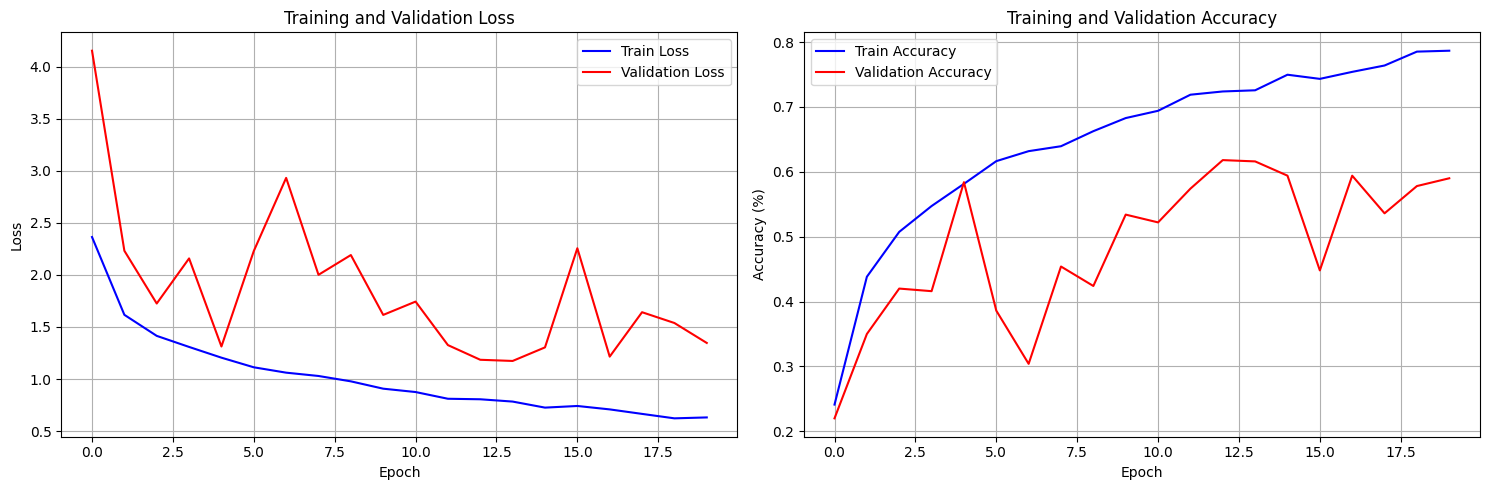

Результаты сохранены в папку: ./training_results/3_2/B
________________________________ VAR - C ____________________________________
----------------------------------
 Всего параметров: 17,377,290
 Обучаемых параметров: 17,377,290
Обучение на 20 эпох...
Лучшая эпоха будет сохранена в ./training_results/3_2/C
 Эпоха 1/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.76s/it, Loss per batch=24.8387, Acc per batch=14.00]


 Train Loss: 2.6060, Train Acc: 20.90%
 Val Loss: 24.8387, Val Acc: 14.00%
 Сохранена лучшая модель с точностью 14.00%
 Эпоха 2/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.70s/it, Loss per batch=3.5493, Acc per batch=23.60]


 Train Loss: 1.6845, Train Acc: 40.68%
 Val Loss: 3.5493, Val Acc: 23.60%
 Сохранена лучшая модель с точностью 23.60%
 Эпоха 3/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.56s/it, Loss per batch=2.5481, Acc per batch=31.40]


 Train Loss: 1.5051, Train Acc: 46.90%
 Val Loss: 2.5481, Val Acc: 31.40%
 Сохранена лучшая модель с точностью 31.40%
 Эпоха 4/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.95s/it, Loss per batch=1.7489, Acc per batch=43.00]


 Train Loss: 1.4110, Train Acc: 50.62%
 Val Loss: 1.7489, Val Acc: 43.00%
 Сохранена лучшая модель с точностью 43.00%
 Эпоха 5/20


Validation: 100%|██████████| 1/1 [00:05<00:00,  5.99s/it, Loss per batch=1.7277, Acc per batch=48.20]


 Train Loss: 1.2709, Train Acc: 56.90%
 Val Loss: 1.7277, Val Acc: 48.20%
 Сохранена лучшая модель с точностью 48.20%
 Эпоха 6/20


Validation: 100%|██████████| 1/1 [00:05<00:00,  5.15s/it, Loss per batch=1.7713, Acc per batch=45.60]


 Train Loss: 1.2029, Train Acc: 58.78%
 Val Loss: 1.7713, Val Acc: 45.60%
 Эпоха 7/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.85s/it, Loss per batch=1.3500, Acc per batch=56.00]


 Train Loss: 1.1758, Train Acc: 59.68%
 Val Loss: 1.3500, Val Acc: 56.00%
 Сохранена лучшая модель с точностью 56.00%
 Эпоха 8/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.88s/it, Loss per batch=1.4611, Acc per batch=55.40]


 Train Loss: 1.1176, Train Acc: 60.84%
 Val Loss: 1.4611, Val Acc: 55.40%
 Эпоха 9/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.85s/it, Loss per batch=2.3326, Acc per batch=36.60]


 Train Loss: 1.0656, Train Acc: 63.00%
 Val Loss: 2.3326, Val Acc: 36.60%
 Эпоха 10/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.85s/it, Loss per batch=2.3776, Acc per batch=40.20]


 Train Loss: 0.9950, Train Acc: 65.64%
 Val Loss: 2.3776, Val Acc: 40.20%
 Эпоха 11/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.51s/it, Loss per batch=1.9315, Acc per batch=47.60]


 Train Loss: 0.9500, Train Acc: 66.92%
 Val Loss: 1.9315, Val Acc: 47.60%
 Эпоха 12/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.45s/it, Loss per batch=2.0150, Acc per batch=45.00]


 Train Loss: 0.9035, Train Acc: 68.92%
 Val Loss: 2.0150, Val Acc: 45.00%
 Эпоха 13/20


Validation: 100%|██████████| 1/1 [00:05<00:00,  5.52s/it, Loss per batch=1.2630, Acc per batch=59.00]


 Train Loss: 0.8538, Train Acc: 70.62%
 Val Loss: 1.2630, Val Acc: 59.00%
 Сохранена лучшая модель с точностью 59.00%
 Эпоха 14/20


Validation: 100%|██████████| 1/1 [00:06<00:00,  6.08s/it, Loss per batch=2.5501, Acc per batch=33.40]


 Train Loss: 0.8610, Train Acc: 69.90%
 Val Loss: 2.5501, Val Acc: 33.40%
 Эпоха 15/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.92s/it, Loss per batch=2.1482, Acc per batch=45.00]


 Train Loss: 0.8194, Train Acc: 71.74%
 Val Loss: 2.1482, Val Acc: 45.00%
 Эпоха 16/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.91s/it, Loss per batch=2.1849, Acc per batch=40.60]


 Train Loss: 0.7879, Train Acc: 72.58%
 Val Loss: 2.1849, Val Acc: 40.60%
 Эпоха 17/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.94s/it, Loss per batch=2.2931, Acc per batch=43.60]


 Train Loss: 0.7766, Train Acc: 72.78%
 Val Loss: 2.2931, Val Acc: 43.60%
 Эпоха 18/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.86s/it, Loss per batch=1.4692, Acc per batch=55.80]


 Train Loss: 0.7499, Train Acc: 74.36%
 Val Loss: 1.4692, Val Acc: 55.80%
 Эпоха 19/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.52s/it, Loss per batch=2.0344, Acc per batch=46.40]


 Train Loss: 0.7152, Train Acc: 75.64%
 Val Loss: 2.0344, Val Acc: 46.40%
 Эпоха 20/20


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.54s/it, Loss per batch=1.7048, Acc per batch=51.40]


 Train Loss: 0.7469, Train Acc: 73.90%
 Val Loss: 1.7048, Val Acc: 51.40%
------------------------------------------------------------------------------------
История сохранена в ./training_results/3_2/C


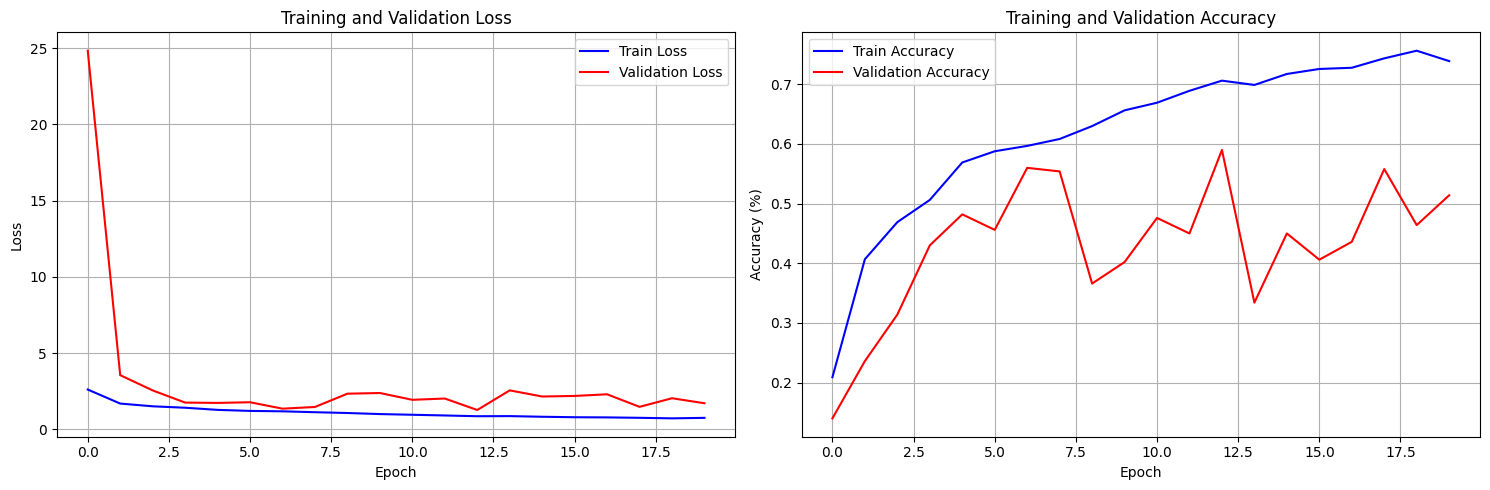

Результаты сохранены в папку: ./training_results/3_2/C


In [388]:
var_layers = {'A':[1,1,1,1], 'B':[2,2,2,2], 'C':[3,3,3,3]}

history_res = []

for VAR, BLOCKS in var_layers.items():

    print(f'________________________________ VAR - {VAR} ____________________________________')
    save_dir = "./training_results/" + VAR

    model = ResNet64(BLOCKS, 10)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   

    print_model_params(model)
    
    history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20,
    experiment='3_2',
    var=VAR
    )
    
    print('------------------------------------------------------------------------------------')
    history_res.append(history)
    plot_training_history(history,experiment='3_2',var=VAR)
    

# 3.3 Функции активации

In [389]:
## ResNet
class ResNet(nn.Module):
    def __init__(self,  blocks, activation_func, num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.conv2d = nn.Conv2d(3, 64, kernel_size=3,stride=1)
        self.layer_1 = self._make_layer( blocks[0], 32, stride=1)
        self.layer_2 = self._make_layer( blocks[1], 64, stride=2)
        self.layer_3 = self._make_layer( blocks[2], 128, stride=2)
        self.layer_4 = self._make_layer( blocks[3], 256, stride=2)
        #
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.max_pool = nn.MaxPool2d(3,2,1)
        #
        self.mlp = nn.Linear(in_features=256 ,out_features=num_classes)
        self.Bn = nn.BatchNorm2d(64)
        self.act = activation_func

    def _make_layer(self, blocks, out_channels, stride=1):
        layers = []
        if stride != 1 or self.in_channels != out_channels:
            layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample=True))
        self.in_channels = out_channels
        # Последующие блоки - сохраняют размер
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels, stride=1,downsample=False))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.Bn(self.conv2d(x))
        x = self.act(x)
        x = self.max_pool(x)
        x_l1 = self.layer_1(x)
        x_l2 = self.layer_2(x_l1)
        x_l3 = self.layer_3(x_l2)
        x_l4 = self.layer_4(x_l3)
        X = self.gap(x_l4)
        X = X.squeeze(-1).squeeze(-1)
        out = self.mlp(X)
        return  out

________________________________ VAR - ReLU ____________________________________
----------------------------------
 Всего параметров: 2,812,330
 Обучаемых параметров: 2,812,330
Обучение на 20 эпох...
Лучшая эпоха будет сохранена в ./training_results/3_3/ReLU
 Эпоха 1/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, Loss per batch=2.0828, Acc per batch=18.60]


 Train Loss: 2.0841, Train Acc: 27.10%
 Val Loss: 2.0828, Val Acc: 18.60%
 Сохранена лучшая модель с точностью 18.60%
 Эпоха 2/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, Loss per batch=3.0531, Acc per batch=26.60]


 Train Loss: 1.5312, Train Acc: 46.34%
 Val Loss: 3.0531, Val Acc: 26.60%
 Сохранена лучшая модель с точностью 26.60%
 Эпоха 3/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, Loss per batch=1.7319, Acc per batch=44.40]


 Train Loss: 1.3625, Train Acc: 52.74%
 Val Loss: 1.7319, Val Acc: 44.40%
 Сохранена лучшая модель с точностью 44.40%
 Эпоха 4/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, Loss per batch=2.0814, Acc per batch=39.40]


 Train Loss: 1.2283, Train Acc: 58.24%
 Val Loss: 2.0814, Val Acc: 39.40%
 Эпоха 5/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, Loss per batch=1.8616, Acc per batch=43.60]


 Train Loss: 1.1048, Train Acc: 62.18%
 Val Loss: 1.8616, Val Acc: 43.60%
 Эпоха 6/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, Loss per batch=1.9774, Acc per batch=44.80]


 Train Loss: 1.0269, Train Acc: 64.40%
 Val Loss: 1.9774, Val Acc: 44.80%
 Сохранена лучшая модель с точностью 44.80%
 Эпоха 7/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, Loss per batch=1.6036, Acc per batch=50.20]


 Train Loss: 0.9925, Train Acc: 65.30%
 Val Loss: 1.6036, Val Acc: 50.20%
 Сохранена лучшая модель с точностью 50.20%
 Эпоха 8/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, Loss per batch=1.5475, Acc per batch=52.60]


 Train Loss: 0.9377, Train Acc: 67.52%
 Val Loss: 1.5475, Val Acc: 52.60%
 Сохранена лучшая модель с точностью 52.60%
 Эпоха 9/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, Loss per batch=1.8201, Acc per batch=48.60]


 Train Loss: 0.9059, Train Acc: 68.52%
 Val Loss: 1.8201, Val Acc: 48.60%
 Эпоха 10/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, Loss per batch=2.0207, Acc per batch=43.00]


 Train Loss: 0.8577, Train Acc: 70.26%
 Val Loss: 2.0207, Val Acc: 43.00%
 Эпоха 11/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, Loss per batch=1.3595, Acc per batch=54.80]


 Train Loss: 0.8094, Train Acc: 71.44%
 Val Loss: 1.3595, Val Acc: 54.80%
 Сохранена лучшая модель с точностью 54.80%
 Эпоха 12/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, Loss per batch=1.7635, Acc per batch=50.80]


 Train Loss: 0.7664, Train Acc: 73.40%
 Val Loss: 1.7635, Val Acc: 50.80%
 Эпоха 13/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, Loss per batch=2.3348, Acc per batch=46.20]


 Train Loss: 0.7309, Train Acc: 73.86%
 Val Loss: 2.3348, Val Acc: 46.20%
 Эпоха 14/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, Loss per batch=2.1658, Acc per batch=46.80]


 Train Loss: 0.6897, Train Acc: 76.06%
 Val Loss: 2.1658, Val Acc: 46.80%
 Эпоха 15/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, Loss per batch=2.1107, Acc per batch=45.40]


 Train Loss: 0.6750, Train Acc: 76.42%
 Val Loss: 2.1107, Val Acc: 45.40%
 Эпоха 16/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, Loss per batch=2.3388, Acc per batch=44.80]


 Train Loss: 0.6527, Train Acc: 76.88%
 Val Loss: 2.3388, Val Acc: 44.80%
 Эпоха 17/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, Loss per batch=1.6708, Acc per batch=54.60]


 Train Loss: 0.6363, Train Acc: 77.44%
 Val Loss: 1.6708, Val Acc: 54.60%
 Эпоха 18/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, Loss per batch=2.1883, Acc per batch=42.40]


 Train Loss: 0.5929, Train Acc: 79.48%
 Val Loss: 2.1883, Val Acc: 42.40%
 Эпоха 19/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, Loss per batch=1.4600, Acc per batch=52.20]


 Train Loss: 0.5954, Train Acc: 79.66%
 Val Loss: 1.4600, Val Acc: 52.20%
 Эпоха 20/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, Loss per batch=1.9605, Acc per batch=49.80]


 Train Loss: 0.5780, Train Acc: 79.04%
 Val Loss: 1.9605, Val Acc: 49.80%
------------------------------------------------------------------------------------
История сохранена в ./training_results/3_3/ReLU


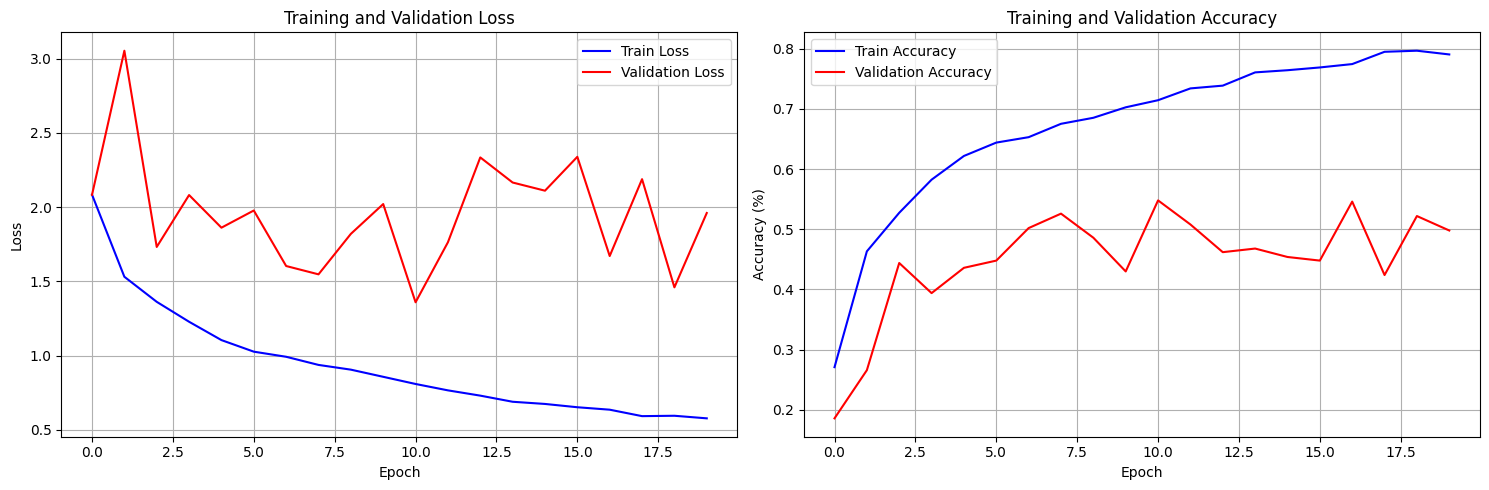

Результаты сохранены в папку: ./training_results/3_3/ReLU
________________________________ VAR - LeakyReLU ____________________________________
----------------------------------
 Всего параметров: 2,812,330
 Обучаемых параметров: 2,812,330
Обучение на 20 эпох...
Лучшая эпоха будет сохранена в ./training_results/3_3/LeakyReLU
 Эпоха 1/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, Loss per batch=2.2775, Acc per batch=17.80]


 Train Loss: 2.0753, Train Acc: 26.08%
 Val Loss: 2.2775, Val Acc: 17.80%
 Сохранена лучшая модель с точностью 17.80%
 Эпоха 2/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, Loss per batch=1.8666, Acc per batch=39.80]


 Train Loss: 1.5040, Train Acc: 46.84%
 Val Loss: 1.8666, Val Acc: 39.80%
 Сохранена лучшая модель с точностью 39.80%
 Эпоха 3/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, Loss per batch=1.7082, Acc per batch=47.60]


 Train Loss: 1.3459, Train Acc: 53.44%
 Val Loss: 1.7082, Val Acc: 47.60%
 Сохранена лучшая модель с точностью 47.60%
 Эпоха 4/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, Loss per batch=1.3827, Acc per batch=56.40]


 Train Loss: 1.1907, Train Acc: 59.00%
 Val Loss: 1.3827, Val Acc: 56.40%
 Сохранена лучшая модель с точностью 56.40%
 Эпоха 5/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, Loss per batch=1.4328, Acc per batch=52.40]


 Train Loss: 1.0641, Train Acc: 63.66%
 Val Loss: 1.4328, Val Acc: 52.40%
 Эпоха 6/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, Loss per batch=1.8535, Acc per batch=47.80]


 Train Loss: 1.0204, Train Acc: 65.06%
 Val Loss: 1.8535, Val Acc: 47.80%
 Эпоха 7/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, Loss per batch=2.1994, Acc per batch=39.80]


 Train Loss: 0.9502, Train Acc: 67.18%
 Val Loss: 2.1994, Val Acc: 39.80%
 Эпоха 8/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, Loss per batch=1.2787, Acc per batch=57.00]


 Train Loss: 0.8993, Train Acc: 68.52%
 Val Loss: 1.2787, Val Acc: 57.00%
 Сохранена лучшая модель с точностью 57.00%
 Эпоха 9/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, Loss per batch=1.6593, Acc per batch=45.80]


 Train Loss: 0.8746, Train Acc: 69.42%
 Val Loss: 1.6593, Val Acc: 45.80%
 Эпоха 10/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, Loss per batch=1.6608, Acc per batch=49.60]


 Train Loss: 0.8153, Train Acc: 71.28%
 Val Loss: 1.6608, Val Acc: 49.60%
 Эпоха 11/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, Loss per batch=1.1669, Acc per batch=62.80]


 Train Loss: 0.7775, Train Acc: 72.74%
 Val Loss: 1.1669, Val Acc: 62.80%
 Сохранена лучшая модель с точностью 62.80%
 Эпоха 12/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, Loss per batch=1.3760, Acc per batch=55.80]


 Train Loss: 0.7370, Train Acc: 74.02%
 Val Loss: 1.3760, Val Acc: 55.80%
 Эпоха 13/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, Loss per batch=1.6550, Acc per batch=53.60]


 Train Loss: 0.7152, Train Acc: 74.84%
 Val Loss: 1.6550, Val Acc: 53.60%
 Эпоха 14/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, Loss per batch=2.2926, Acc per batch=43.80]


 Train Loss: 0.6931, Train Acc: 75.68%
 Val Loss: 2.2926, Val Acc: 43.80%
 Эпоха 15/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, Loss per batch=1.7423, Acc per batch=51.40]


 Train Loss: 0.6667, Train Acc: 77.00%
 Val Loss: 1.7423, Val Acc: 51.40%
 Эпоха 16/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, Loss per batch=1.6952, Acc per batch=51.80]


 Train Loss: 0.6603, Train Acc: 76.86%
 Val Loss: 1.6952, Val Acc: 51.80%
 Эпоха 17/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, Loss per batch=1.3609, Acc per batch=60.60]


 Train Loss: 0.6176, Train Acc: 78.92%
 Val Loss: 1.3609, Val Acc: 60.60%
 Эпоха 18/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, Loss per batch=1.6172, Acc per batch=52.60]


 Train Loss: 0.5951, Train Acc: 79.66%
 Val Loss: 1.6172, Val Acc: 52.60%
 Эпоха 19/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, Loss per batch=1.9059, Acc per batch=47.60]


 Train Loss: 0.5569, Train Acc: 80.10%
 Val Loss: 1.9059, Val Acc: 47.60%
 Эпоха 20/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, Loss per batch=1.8673, Acc per batch=52.60]


 Train Loss: 0.5545, Train Acc: 80.80%
 Val Loss: 1.8673, Val Acc: 52.60%
------------------------------------------------------------------------------------
История сохранена в ./training_results/3_3/LeakyReLU


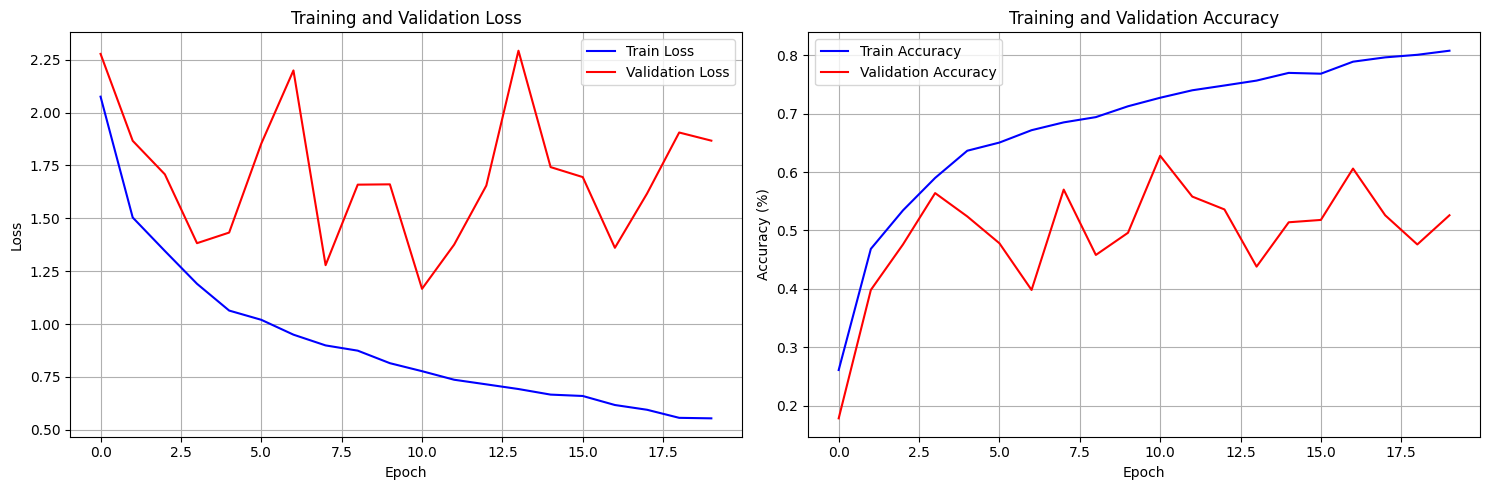

Результаты сохранены в папку: ./training_results/3_3/LeakyReLU
________________________________ VAR - ELU ____________________________________
----------------------------------
 Всего параметров: 2,812,330
 Обучаемых параметров: 2,812,330
Обучение на 20 эпох...
Лучшая эпоха будет сохранена в ./training_results/3_3/ELU
 Эпоха 1/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, Loss per batch=2.1819, Acc per batch=21.40]


 Train Loss: 2.0645, Train Acc: 26.42%
 Val Loss: 2.1819, Val Acc: 21.40%
 Сохранена лучшая модель с точностью 21.40%
 Эпоха 2/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, Loss per batch=2.1963, Acc per batch=27.00]


 Train Loss: 1.5171, Train Acc: 46.94%
 Val Loss: 2.1963, Val Acc: 27.00%
 Сохранена лучшая модель с точностью 27.00%
 Эпоха 3/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it, Loss per batch=1.6194, Acc per batch=47.00]


 Train Loss: 1.3018, Train Acc: 55.62%
 Val Loss: 1.6194, Val Acc: 47.00%
 Сохранена лучшая модель с точностью 47.00%
 Эпоха 4/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it, Loss per batch=1.2697, Acc per batch=58.20]


 Train Loss: 1.1731, Train Acc: 59.94%
 Val Loss: 1.2697, Val Acc: 58.20%
 Сохранена лучшая модель с точностью 58.20%
 Эпоха 5/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, Loss per batch=1.9985, Acc per batch=45.40]


 Train Loss: 1.0520, Train Acc: 63.46%
 Val Loss: 1.9985, Val Acc: 45.40%
 Эпоха 6/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, Loss per batch=3.0001, Acc per batch=37.80]


 Train Loss: 0.9927, Train Acc: 66.40%
 Val Loss: 3.0001, Val Acc: 37.80%
 Эпоха 7/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, Loss per batch=2.1127, Acc per batch=39.40]


 Train Loss: 0.9611, Train Acc: 67.12%
 Val Loss: 2.1127, Val Acc: 39.40%
 Эпоха 8/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, Loss per batch=1.2625, Acc per batch=59.00]


 Train Loss: 0.8940, Train Acc: 69.30%
 Val Loss: 1.2625, Val Acc: 59.00%
 Сохранена лучшая модель с точностью 59.00%
 Эпоха 9/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, Loss per batch=2.1553, Acc per batch=47.60]


 Train Loss: 0.8623, Train Acc: 70.32%
 Val Loss: 2.1553, Val Acc: 47.60%
 Эпоха 10/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, Loss per batch=1.6982, Acc per batch=51.80]


 Train Loss: 0.8102, Train Acc: 70.86%
 Val Loss: 1.6982, Val Acc: 51.80%
 Эпоха 11/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, Loss per batch=3.3487, Acc per batch=37.40]


 Train Loss: 0.7682, Train Acc: 73.72%
 Val Loss: 3.3487, Val Acc: 37.40%
 Эпоха 12/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, Loss per batch=2.1539, Acc per batch=45.80]


 Train Loss: 0.7572, Train Acc: 73.82%
 Val Loss: 2.1539, Val Acc: 45.80%
 Эпоха 13/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, Loss per batch=1.5057, Acc per batch=53.60]


 Train Loss: 0.7043, Train Acc: 75.64%
 Val Loss: 1.5057, Val Acc: 53.60%
 Эпоха 14/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, Loss per batch=3.1708, Acc per batch=36.60]


 Train Loss: 0.6573, Train Acc: 77.22%
 Val Loss: 3.1708, Val Acc: 36.60%
 Эпоха 15/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, Loss per batch=1.6661, Acc per batch=50.80]


 Train Loss: 0.6671, Train Acc: 76.94%
 Val Loss: 1.6661, Val Acc: 50.80%
 Эпоха 16/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, Loss per batch=2.6614, Acc per batch=40.60]


 Train Loss: 0.6200, Train Acc: 78.18%
 Val Loss: 2.6614, Val Acc: 40.60%
 Эпоха 17/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, Loss per batch=2.2173, Acc per batch=44.40]


 Train Loss: 0.6090, Train Acc: 79.22%
 Val Loss: 2.2173, Val Acc: 44.40%
 Эпоха 18/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, Loss per batch=2.7961, Acc per batch=39.40]


 Train Loss: 0.5931, Train Acc: 79.26%
 Val Loss: 2.7961, Val Acc: 39.40%
 Эпоха 19/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, Loss per batch=1.2748, Acc per batch=60.20]


 Train Loss: 0.5828, Train Acc: 79.92%
 Val Loss: 1.2748, Val Acc: 60.20%
 Сохранена лучшая модель с точностью 60.20%
 Эпоха 20/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, Loss per batch=1.7356, Acc per batch=53.80]


 Train Loss: 0.5520, Train Acc: 80.94%
 Val Loss: 1.7356, Val Acc: 53.80%
------------------------------------------------------------------------------------
История сохранена в ./training_results/3_3/ELU


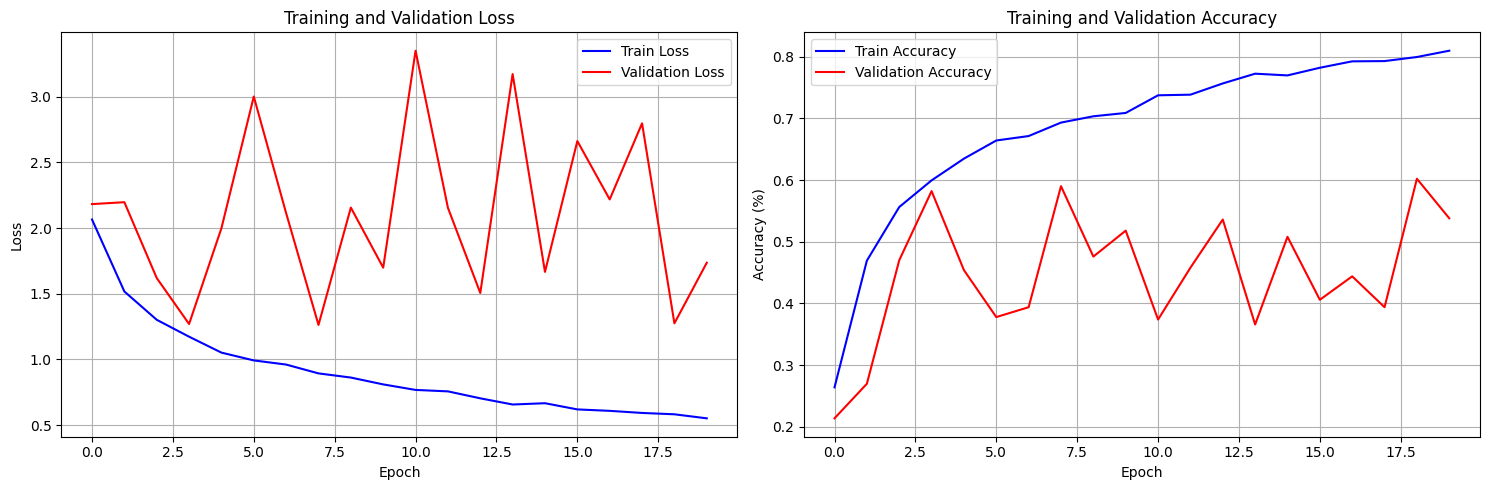

Результаты сохранены в папку: ./training_results/3_3/ELU
________________________________ VAR - GELU ____________________________________
----------------------------------
 Всего параметров: 2,812,330
 Обучаемых параметров: 2,812,330
Обучение на 20 эпох...
Лучшая эпоха будет сохранена в ./training_results/3_3/GELU
 Эпоха 1/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, Loss per batch=2.2463, Acc per batch=15.60]


 Train Loss: 2.0362, Train Acc: 28.34%
 Val Loss: 2.2463, Val Acc: 15.60%
 Сохранена лучшая модель с точностью 15.60%
 Эпоха 2/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, Loss per batch=2.1212, Acc per batch=29.20]


 Train Loss: 1.4795, Train Acc: 48.78%
 Val Loss: 2.1212, Val Acc: 29.20%
 Сохранена лучшая модель с точностью 29.20%
 Эпоха 3/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it, Loss per batch=1.9205, Acc per batch=42.40]


 Train Loss: 1.2955, Train Acc: 55.78%
 Val Loss: 1.9205, Val Acc: 42.40%
 Сохранена лучшая модель с точностью 42.40%
 Эпоха 4/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, Loss per batch=1.8075, Acc per batch=43.00]


 Train Loss: 1.1554, Train Acc: 59.40%
 Val Loss: 1.8075, Val Acc: 43.00%
 Сохранена лучшая модель с точностью 43.00%
 Эпоха 5/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, Loss per batch=1.6581, Acc per batch=48.80]


 Train Loss: 1.0590, Train Acc: 63.22%
 Val Loss: 1.6581, Val Acc: 48.80%
 Сохранена лучшая модель с точностью 48.80%
 Эпоха 6/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, Loss per batch=2.3386, Acc per batch=39.20]


 Train Loss: 1.0088, Train Acc: 65.18%
 Val Loss: 2.3386, Val Acc: 39.20%
 Эпоха 7/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, Loss per batch=1.7029, Acc per batch=49.40]


 Train Loss: 0.9558, Train Acc: 67.48%
 Val Loss: 1.7029, Val Acc: 49.40%
 Сохранена лучшая модель с точностью 49.40%
 Эпоха 8/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, Loss per batch=1.8683, Acc per batch=46.80]


 Train Loss: 0.8920, Train Acc: 69.12%
 Val Loss: 1.8683, Val Acc: 46.80%
 Эпоха 9/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, Loss per batch=2.3210, Acc per batch=43.20]


 Train Loss: 0.8519, Train Acc: 70.42%
 Val Loss: 2.3210, Val Acc: 43.20%
 Эпоха 10/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, Loss per batch=1.6910, Acc per batch=51.20]


 Train Loss: 0.8098, Train Acc: 71.76%
 Val Loss: 1.6910, Val Acc: 51.20%
 Сохранена лучшая модель с точностью 51.20%
 Эпоха 11/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, Loss per batch=1.4751, Acc per batch=55.60]


 Train Loss: 0.7770, Train Acc: 73.72%
 Val Loss: 1.4751, Val Acc: 55.60%
 Сохранена лучшая модель с точностью 55.60%
 Эпоха 12/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, Loss per batch=2.0010, Acc per batch=50.60]


 Train Loss: 0.7404, Train Acc: 74.38%
 Val Loss: 2.0010, Val Acc: 50.60%
 Эпоха 13/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, Loss per batch=1.4007, Acc per batch=56.40]


 Train Loss: 0.7422, Train Acc: 73.60%
 Val Loss: 1.4007, Val Acc: 56.40%
 Сохранена лучшая модель с точностью 56.40%
 Эпоха 14/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, Loss per batch=1.6079, Acc per batch=52.20]


 Train Loss: 0.6763, Train Acc: 76.54%
 Val Loss: 1.6079, Val Acc: 52.20%
 Эпоха 15/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, Loss per batch=1.5164, Acc per batch=54.60]


 Train Loss: 0.6442, Train Acc: 77.88%
 Val Loss: 1.5164, Val Acc: 54.60%
 Эпоха 16/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, Loss per batch=2.1465, Acc per batch=49.60]


 Train Loss: 0.6263, Train Acc: 77.76%
 Val Loss: 2.1465, Val Acc: 49.60%
 Эпоха 17/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, Loss per batch=1.4232, Acc per batch=60.20]


 Train Loss: 0.6109, Train Acc: 78.66%
 Val Loss: 1.4232, Val Acc: 60.20%
 Сохранена лучшая модель с точностью 60.20%
 Эпоха 18/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, Loss per batch=2.1151, Acc per batch=46.20]


 Train Loss: 0.5736, Train Acc: 79.68%
 Val Loss: 2.1151, Val Acc: 46.20%
 Эпоха 19/20


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, Loss per batch=1.2103, Acc per batch=61.60]


 Train Loss: 0.5505, Train Acc: 81.16%
 Val Loss: 1.2103, Val Acc: 61.60%
 Сохранена лучшая модель с точностью 61.60%
 Эпоха 20/20


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, Loss per batch=1.8219, Acc per batch=52.00]


 Train Loss: 0.5389, Train Acc: 81.26%
 Val Loss: 1.8219, Val Acc: 52.00%
------------------------------------------------------------------------------------
История сохранена в ./training_results/3_3/GELU


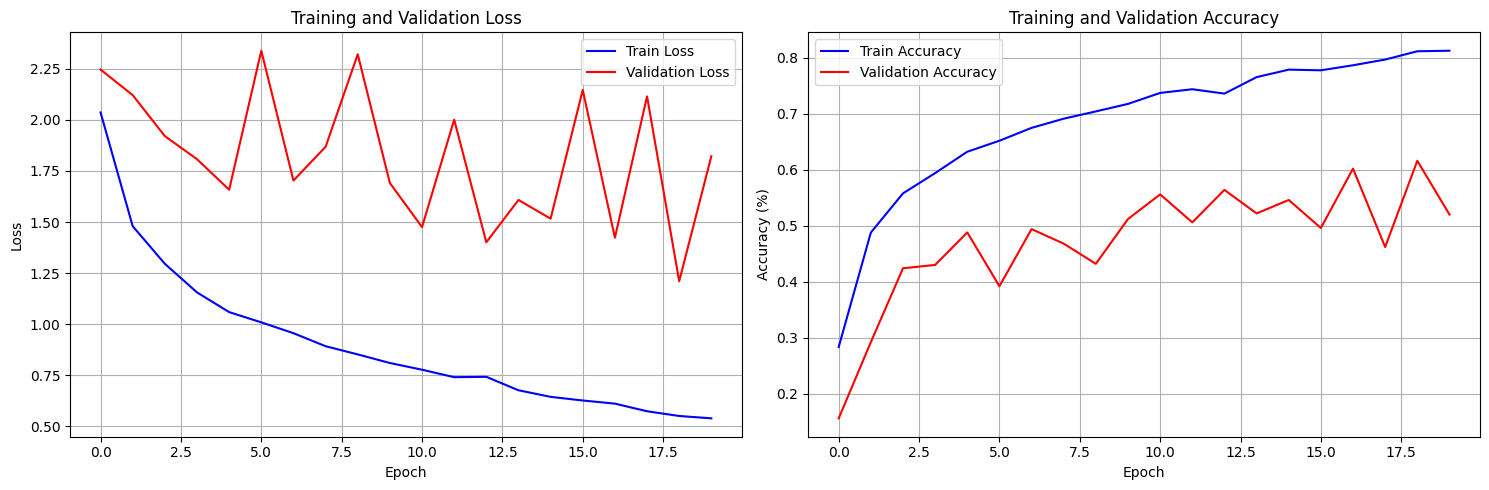

Результаты сохранены в папку: ./training_results/3_3/GELU


In [390]:
acts = [nn.ReLU(), nn.LeakyReLU(), nn.ELU(), nn.GELU()]
names = ['ReLU','LeakyReLU', 'ELU','GELU']
history_res_3_3 = []
for name, act in zip(names, acts):
    print(f'________________________________ VAR - {name} ____________________________________')
    model = ResNet([2, 2, 2, 2], act, 10)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   

    print_model_params(model)
    
    history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20,
    experiment='3_3',
    var=name
    )
    
    print('------------------------------------------------------------------------------------')
    history_res_3_3.append(history)

    plot_training_history(history,experiment='3_3',var=name)

# Final

In [391]:
final_model = ResNet([2, 2, 2, 2], nn.LeakyReLU(), 10)
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
history = train_model(
    model=final_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=40,
    experiment='Final',
    var=None
    )

Обучение на 40 эпох...
Лучшая эпоха будет сохранена в ./training_results/Final
 Эпоха 1/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, Loss per batch=1.9954, Acc per batch=28.20]


 Train Loss: 2.0439, Train Acc: 28.68%
 Val Loss: 1.9954, Val Acc: 28.20%
 Сохранена лучшая модель с точностью 28.20%
 Эпоха 2/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, Loss per batch=2.1869, Acc per batch=30.40]


 Train Loss: 1.5191, Train Acc: 46.60%
 Val Loss: 2.1869, Val Acc: 30.40%
 Сохранена лучшая модель с точностью 30.40%
 Эпоха 3/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, Loss per batch=2.6879, Acc per batch=29.40]


 Train Loss: 1.3226, Train Acc: 54.08%
 Val Loss: 2.6879, Val Acc: 29.40%
 Эпоха 4/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, Loss per batch=1.9970, Acc per batch=47.60]


 Train Loss: 1.1669, Train Acc: 60.34%
 Val Loss: 1.9970, Val Acc: 47.60%
 Сохранена лучшая модель с точностью 47.60%
 Эпоха 5/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, Loss per batch=1.3455, Acc per batch=54.20]


 Train Loss: 1.0801, Train Acc: 62.72%
 Val Loss: 1.3455, Val Acc: 54.20%
 Сохранена лучшая модель с точностью 54.20%
 Эпоха 6/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, Loss per batch=1.9444, Acc per batch=45.60]


 Train Loss: 0.9860, Train Acc: 66.24%
 Val Loss: 1.9444, Val Acc: 45.60%
 Эпоха 7/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, Loss per batch=2.3516, Acc per batch=40.60]


 Train Loss: 0.9538, Train Acc: 67.08%
 Val Loss: 2.3516, Val Acc: 40.60%
 Эпоха 8/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, Loss per batch=1.8157, Acc per batch=45.20]


 Train Loss: 0.8951, Train Acc: 69.08%
 Val Loss: 1.8157, Val Acc: 45.20%
 Эпоха 9/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, Loss per batch=1.5578, Acc per batch=52.40]


 Train Loss: 0.8255, Train Acc: 71.80%
 Val Loss: 1.5578, Val Acc: 52.40%
 Эпоха 10/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, Loss per batch=1.7019, Acc per batch=50.20]


 Train Loss: 0.8133, Train Acc: 71.94%
 Val Loss: 1.7019, Val Acc: 50.20%
 Эпоха 11/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, Loss per batch=1.5108, Acc per batch=51.80]


 Train Loss: 0.7582, Train Acc: 73.62%
 Val Loss: 1.5108, Val Acc: 51.80%
 Эпоха 12/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, Loss per batch=2.5194, Acc per batch=37.00]


 Train Loss: 0.7231, Train Acc: 75.02%
 Val Loss: 2.5194, Val Acc: 37.00%
 Эпоха 13/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, Loss per batch=2.5844, Acc per batch=41.20]


 Train Loss: 0.7266, Train Acc: 74.88%
 Val Loss: 2.5844, Val Acc: 41.20%
 Эпоха 14/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, Loss per batch=1.1743, Acc per batch=62.20]


 Train Loss: 0.6971, Train Acc: 75.66%
 Val Loss: 1.1743, Val Acc: 62.20%
 Сохранена лучшая модель с точностью 62.20%
 Эпоха 15/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, Loss per batch=1.7973, Acc per batch=46.40]


 Train Loss: 0.6329, Train Acc: 78.00%
 Val Loss: 1.7973, Val Acc: 46.40%
 Эпоха 16/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, Loss per batch=2.1847, Acc per batch=43.40]


 Train Loss: 0.6149, Train Acc: 78.26%
 Val Loss: 2.1847, Val Acc: 43.40%
 Эпоха 17/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, Loss per batch=2.0868, Acc per batch=43.00]


 Train Loss: 0.5789, Train Acc: 79.64%
 Val Loss: 2.0868, Val Acc: 43.00%
 Эпоха 18/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, Loss per batch=1.8951, Acc per batch=46.60]


 Train Loss: 0.5750, Train Acc: 79.46%
 Val Loss: 1.8951, Val Acc: 46.60%
 Эпоха 19/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, Loss per batch=2.2123, Acc per batch=50.80]


 Train Loss: 0.5444, Train Acc: 80.60%
 Val Loss: 2.2123, Val Acc: 50.80%
 Эпоха 20/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, Loss per batch=1.2525, Acc per batch=63.20]


 Train Loss: 0.5070, Train Acc: 82.08%
 Val Loss: 1.2525, Val Acc: 63.20%
 Сохранена лучшая модель с точностью 63.20%
 Эпоха 21/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, Loss per batch=1.6440, Acc per batch=55.60]


 Train Loss: 0.5060, Train Acc: 82.30%
 Val Loss: 1.6440, Val Acc: 55.60%
 Эпоха 22/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, Loss per batch=2.0892, Acc per batch=50.00]


 Train Loss: 0.5027, Train Acc: 82.16%
 Val Loss: 2.0892, Val Acc: 50.00%
 Эпоха 23/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, Loss per batch=2.2015, Acc per batch=48.80]


 Train Loss: 0.4755, Train Acc: 82.96%
 Val Loss: 2.2015, Val Acc: 48.80%
 Эпоха 24/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, Loss per batch=1.5731, Acc per batch=55.60]


 Train Loss: 0.4577, Train Acc: 84.06%
 Val Loss: 1.5731, Val Acc: 55.60%
 Эпоха 25/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, Loss per batch=3.7756, Acc per batch=30.60]


 Train Loss: 0.4625, Train Acc: 83.66%
 Val Loss: 3.7756, Val Acc: 30.60%
 Эпоха 26/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, Loss per batch=2.4282, Acc per batch=44.00]


 Train Loss: 0.4545, Train Acc: 83.62%
 Val Loss: 2.4282, Val Acc: 44.00%
 Эпоха 27/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, Loss per batch=1.6686, Acc per batch=54.40]


 Train Loss: 0.4172, Train Acc: 84.46%
 Val Loss: 1.6686, Val Acc: 54.40%
 Эпоха 28/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, Loss per batch=1.9387, Acc per batch=45.60]


 Train Loss: 0.4015, Train Acc: 85.36%
 Val Loss: 1.9387, Val Acc: 45.60%
 Эпоха 29/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, Loss per batch=1.8327, Acc per batch=52.20]


 Train Loss: 0.3879, Train Acc: 86.40%
 Val Loss: 1.8327, Val Acc: 52.20%
 Эпоха 30/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, Loss per batch=1.4865, Acc per batch=59.80]


 Train Loss: 0.3372, Train Acc: 88.24%
 Val Loss: 1.4865, Val Acc: 59.80%
 Эпоха 31/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, Loss per batch=1.4036, Acc per batch=60.80]


 Train Loss: 0.3427, Train Acc: 88.14%
 Val Loss: 1.4036, Val Acc: 60.80%
 Эпоха 32/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, Loss per batch=1.9072, Acc per batch=53.20]


 Train Loss: 0.3265, Train Acc: 88.50%
 Val Loss: 1.9072, Val Acc: 53.20%
 Эпоха 33/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, Loss per batch=2.1316, Acc per batch=47.00]


 Train Loss: 0.3052, Train Acc: 88.96%
 Val Loss: 2.1316, Val Acc: 47.00%
 Эпоха 34/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it, Loss per batch=2.2204, Acc per batch=50.00]


 Train Loss: 0.2864, Train Acc: 89.86%
 Val Loss: 2.2204, Val Acc: 50.00%
 Эпоха 35/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, Loss per batch=2.0931, Acc per batch=47.80]


 Train Loss: 0.2691, Train Acc: 90.74%
 Val Loss: 2.0931, Val Acc: 47.80%
 Эпоха 36/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, Loss per batch=2.4117, Acc per batch=48.60]


 Train Loss: 0.2722, Train Acc: 89.74%
 Val Loss: 2.4117, Val Acc: 48.60%
 Эпоха 37/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, Loss per batch=2.2349, Acc per batch=50.00]


 Train Loss: 0.2445, Train Acc: 91.12%
 Val Loss: 2.2349, Val Acc: 50.00%
 Эпоха 38/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, Loss per batch=2.2558, Acc per batch=47.40]


 Train Loss: 0.2512, Train Acc: 91.34%
 Val Loss: 2.2558, Val Acc: 47.40%
 Эпоха 39/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, Loss per batch=2.0449, Acc per batch=51.80]


 Train Loss: 0.2269, Train Acc: 92.04%
 Val Loss: 2.0449, Val Acc: 51.80%
 Эпоха 40/40


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, Loss per batch=1.7010, Acc per batch=59.00]

 Train Loss: 0.2410, Train Acc: 91.74%
 Val Loss: 1.7010, Val Acc: 59.00%


In [481]:
print_model_params(final_model)

----------------------------------
 Всего параметров: 2,812,330
 Обучаемых параметров: 2,812,330


# Демонстрация финального решения

In [477]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
def evaluate_model(model, test_loader, device, num_classes):
    """
    Полная оценка модели на test set
    
    Args:
        model: PyTorch модель
        test_loader: DataLoader для test set
        device: устройство (cuda/cpu)
        num_classes: количество классов
    """
    
    model.eval()
    all_predictions = []
    all_targets = []
    
    print("Running evaluation on test set...")
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            all_predictions.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Преобразуем в numpy arrays
    all_predictions = np.array(all_predictions).flatten()
    all_targets = np.array(all_targets)
    
    # Вычисляем метрики
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average=None, zero_division=0)
    recall = recall_score(all_targets, all_predictions, average=None, zero_division=0)
    f1 = f1_score(all_targets, all_predictions, average=None, zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': all_predictions,
        'targets': all_targets
    }
def print_metric(metric, res, metric_name):
    for i , (p, name) in enumerate( zip(res[metric], my_dict.values()) ):
        print(f'На классе {name} (Лейбл {i}) - {metric_name} порядка {p:.2f}')

In [392]:
final_model_best = ResNet([2, 2, 2, 2], nn.LeakyReLU(), 10)
final_model_best.load_state_dict(torch.load('./training_results/Final/best_model.pth'))

<All keys matched successfully>

In [408]:
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
root = "data/tiny-imagenet-200"

test_dataset = TinyImageNetDataset(root, split='val', transform=test_transform)

test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=True, num_workers=2)

print(f"Test size: {len(test_dataset)}")

Test size: 500


In [471]:
def read_file_to_dict_basic(filename, class_id):
    result = {}
    with open(filename, 'r', encoding='utf-8') as file:
        cnt = 0
        for line in file:
            line = line.strip()  # Убираем лишние пробелы и переносы
            if line:  
                parts = line.split('\t') 
                if len(parts) >= 2:
                    key = parts[0]
                    if key not in class_id:
                        continue
                    value = parts[1]
                    result[cnt] = value
                    cnt +=1
    return result


class_idx=['n02132136','n04146614','n07873807','n02364673','n04507155','n03854065',
           'n03838899','n03733131','n01443537','n07875152']
# Использование
my_dict = read_file_to_dict_basic(os.path.join("data/tiny-imagenet-200", 'words.txt'),
                                  class_idx)


In [472]:
res = evaluate_model(final_model_best,
                     test_loader, 
                     torch.device('cpu'),
                    10)

Running evaluation on test set...


  0%|          | 0/1 [00:00<?, ?it/s]Python(92967) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/kimelfeld/Library/Python/3.9/lib/python/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/kimelfeld/Library/Python/3.9/lib/python/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
Python(92968) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|

In [479]:
print('Общая точность - ', res['accuracy'])

print('__ Точность __')
print_metric('precision', res, 'точность')
print('__ Полнота __')
print_metric('recall', res, 'полнота')



Общая точность -  0.632
__ Точность __
На классе goldfish, Carassius auratus (Лейбл 0) - точность порядка 0.96
На классе brown bear, bruin, Ursus arctos (Лейбл 1) - точность порядка 0.81
На классе guinea pig, Cavia cobaya (Лейбл 2) - точность порядка 0.69
На классе maypole (Лейбл 3) - точность порядка 0.74
На классе oboe, hautboy, hautbois (Лейбл 4) - точность порядка 0.38
На классе organ, pipe organ (Лейбл 5) - точность порядка 0.49
На классе school bus (Лейбл 6) - точность порядка 0.72
На классе umbrella (Лейбл 7) - точность порядка 0.49
На классе pizza, pizza pie (Лейбл 8) - точность порядка 0.90
На классе potpie (Лейбл 9) - точность порядка 0.85
__ Полнота __
На классе goldfish, Carassius auratus (Лейбл 0) - полнота порядка 0.44
На классе brown bear, bruin, Ursus arctos (Лейбл 1) - полнота порядка 0.84
На классе guinea pig, Cavia cobaya (Лейбл 2) - полнота порядка 0.48
На классе maypole (Лейбл 3) - полнота порядка 0.50
На классе oboe, hautboy, hautbois (Лейбл 4) - полнота порядка 0

In [480]:
print('__ F1 __')
print_metric('f1', res, 'F1')

__ F1 __
На классе goldfish, Carassius auratus (Лейбл 0) - F1 порядка 0.60
На классе brown bear, bruin, Ursus arctos (Лейбл 1) - F1 порядка 0.82
На классе guinea pig, Cavia cobaya (Лейбл 2) - F1 порядка 0.56
На классе maypole (Лейбл 3) - F1 порядка 0.60
На классе oboe, hautboy, hautbois (Лейбл 4) - F1 порядка 0.43
На классе organ, pipe organ (Лейбл 5) - F1 порядка 0.63
На классе school bus (Лейбл 6) - F1 порядка 0.63
На классе umbrella (Лейбл 7) - F1 порядка 0.63
На классе pizza, pizza pie (Лейбл 8) - F1 порядка 0.83
На классе potpie (Лейбл 9) - F1 порядка 0.60


In [469]:
res['confusion_matrix']

array([[22,  1,  0,  4,  6,  6,  2,  9,  0,  0],
       [ 0, 42,  0,  0,  3,  4,  0,  1,  0,  0],
       [ 0,  2, 24,  1,  1, 14,  0,  8,  0,  0],
       [ 1,  0,  0, 25,  7,  8,  3,  4,  0,  2],
       [ 0,  2,  0,  1, 25,  7,  2, 11,  0,  2],
       [ 0,  0,  0,  0,  1, 44,  3,  2,  0,  0],
       [ 0,  1,  0,  0, 10,  2, 28,  8,  1,  0],
       [ 0,  0,  0,  1,  2,  1,  1, 45,  0,  0],
       [ 0,  1,  0,  1,  8,  0,  0,  2, 38,  0],
       [ 0,  3, 11,  1,  3,  4,  0,  2,  3, 23]])